In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec/__results__.html
/kaggle/input/word2vec/__notebook__.ipynb
/kaggle/input/word2vec/__output__.json
/kaggle/input/word2vec/custom.css
/kaggle/input/word2vec/output/finetuned.txt
/kaggle/input/word2vec/scratch/scratch.txt
/kaggle/input/nepsa/NepSA.csv
/kaggle/input/pretrained-fasttext/lstm_prev.py
/kaggle/input/pretrained-fasttext/lstm.py
/kaggle/input/pretrained-fasttext/pretrained_word2vec/pretrained_word2vec.txt
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors_vocab.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.vectors_ngrams_lockf.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.wv.vectors.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.fast_text.trainables.syn1neg.npy
/kaggle/input/pretrained-fasttext/pretrained_fasttext/pretrained_fasttext/pretrained.f

# ResLSTM with Word2vec
## Loading word2vec and dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import precision_score,confusion_matrix, precision_recall_curve, classification_report, average_precision_score, ConfusionMatrixDisplay, matthews_corrcoef, f1_score
from pathlib import Path
import shutil, random, copy, multiprocessing

# Custom Dataset function
Path("./custom_dataset").mkdir()
shutil.copy(Path("/kaggle/input/nephased-datasets/torch_datasets/datasets.py"), Path("./custom_dataset/"))
from custom_dataset.datasets import SequenceDataset

# Residual LSTM implementation
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm.py"), Path("./"))
from lstm import ResLSTM

# Embedding model path
word2vec_path = "/kaggle/input/word2vec/output/finetuned.txt"

## Setting Seed for reproducibility

In [3]:
def set_seed(seed=42):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)                      # Python random
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch CUDA
    torch.cuda.manual_seed_all(seed)       # All GPUs
    torch.backends.cudnn.deterministic = True  # Force deterministic ops
    torch.backends.cudnn.benchmark = False     # Disable auto benchmark

set_seed(42)

In [4]:
# Loading the embedder
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)

print(word2vec["ठोक"])

[ 4.74555850e-01  3.54676396e-02 -2.08788857e-01  1.70470998e-01
 -1.18067317e-01  9.29699302e-01 -7.04040453e-02  8.03592801e-01
 -1.27339840e-01 -4.58929420e-01 -3.97410877e-02 -1.26310542e-01
  1.22885859e+00 -2.62806565e-01  5.53501725e-01  1.81062296e-01
 -2.07190886e-01 -7.13008463e-01  1.14000868e-02 -4.11830097e-01
  7.88021564e-01 -1.51249900e-01  3.57702732e-01 -5.45188546e-01
 -4.65510398e-01  5.79088688e-01 -3.39206010e-01 -6.03623629e-01
 -6.29097939e-01 -4.84275103e-01 -4.23519649e-02  1.93168029e-01
 -1.95928156e-01  2.76344717e-02 -3.22212100e-01  6.57154799e-01
 -5.20747662e-01  7.15428650e-01  2.54623979e-01  7.48650551e-01
 -1.47100151e-01 -3.59026686e-04  5.79743922e-01  1.53442368e-01
  5.20630896e-01  2.46685699e-01  1.72282055e-01  8.39064866e-02
  2.88603872e-01 -7.53973067e-01  1.94269344e-01 -5.50153613e-01
  7.15422444e-03 -4.11128074e-01 -8.50513279e-01 -5.57424545e-01
  5.80618441e-01 -1.10639557e-01 -2.66360968e-01  4.20838654e-01
  5.66144228e-01  2.79027

In [5]:
# Adding pad token to word2vec
PAD_TOKEN = "<pad>"

# In W2V models' text file
def add_pad_to_word2vec_model(model, pad_token="<pad>"):
    if pad_token not in model.key_to_index:
        model.add_vector(pad_token, np.zeros(model.vector_size))

add_pad_to_word2vec_model(word2vec)

/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [6]:
# Getting the Dataset
train = torch.load("/kaggle/input/nephased-datasets/torch_datasets/train.pt")
test = torch.load("/kaggle/input/nephased-datasets/torch_datasets/test.pt")
val = torch.load("/kaggle/input/nephased-datasets/torch_datasets/val.pt")

print(len(train["sentences"]))
print(test["sentences"][0])
print(len(test["labels"]))

3765
['गोलि', 'हान्यो', 'तिर्थ', 'लाइ', 'प्रहरी', 'चोर', 'होश', 'प्रबक्ता', '।']
471


## Transforming text to vectors with our custom torch dataset class

In [7]:
# Using custom dataset to get vectors for our tokens
finetuned_train = SequenceDataset(train["sentences"], binary=False, model=word2vec, labels=train["labels"])
finetuned_test = SequenceDataset(test["sentences"], binary=False, model=word2vec, labels=test["labels"])
finetuned_val = SequenceDataset(val["sentences"], binary=False, model=word2vec, labels=val["labels"])

we map labels to general, light_profanity, high_profanity and violence

In [8]:
# label map int to string
label_map = {
    0: 'GENERAL',
    1: 'LIGHT_PROFANITY',
    2: 'HIGH_PROFANITY',
    3: 'VIOLENCE'
}

num_classes= 4

In [9]:
class LabelModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.label_mapping = {
            0: 0,
            1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 3
        }
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        # Apply the specific mapping rules
        original_label = label.item()
        new_label = self.label_mapping.get(original_label, original_label)      
        
        return (features, mask, torch.tensor(new_label, dtype=label.dtype))

finetuned_train = LabelModifiedDataset(finetuned_train)
finetuned_test = LabelModifiedDataset(finetuned_test)
finetuned_val = LabelModifiedDataset(finetuned_val)

In [10]:
print(finetuned_val[0])
print(finetuned_test[0][0])

(tensor([[ 0.4875, -0.4763, -0.5582,  ...,  0.1804,  0.2504,  0.0779],
        [ 2.5083, -1.1859,  0.4436,  ...,  1.2645,  0.3430, -0.1487],
        [ 0.4938, -0.2413, -0.2697,  ...,  0.2207, -0.1110, -0.0940],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, Fal

/kaggle/working/custom_dataset/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(vectors, dtype=torch.float32),


In [11]:
print(finetuned_train[0][0].shape)

torch.Size([100, 300])


In [12]:
print(len(finetuned_train))
print(len(finetuned_test))

3765
471


In [13]:
num_workers = multiprocessing.cpu_count()
train_loader = DataLoader(finetuned_train, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)
test_loader = DataLoader(finetuned_test, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)
val_loader = DataLoader(finetuned_val, batch_size=16, shuffle=True, pin_memory=True, num_workers = 0)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sequence_length, embeddings_size= finetuned_train[0][0].shape
print(sequence_length)
print(embeddings_size)

Using device: cpu
100
300


## Get trainable paramters

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Training Function

In [16]:
def model_train(model, criterion, optimizer, train_loader, val_loader,scheduler=None, 
                save_name=None, epochs=20, patience=3, early_stopping=False, dnn=False, model2=False):
    '''
        Deep Network training function which excpects model, criterion, scheuler, train data loader and val data loader
        Early stopping can be done for regularization by setting early_stopping (default: False)
        and providing early stopping patience (default: 3)
        save_name if provided saves the plot in working directory with "save_name"_loss.png 
        --
        returns : model with least val loss, list of train and val loss per epoch
        
    '''

    if not isinstance(epochs, int) or epochs <= 0:
        raise ValueError("epochs must be a positive integer.")
    
    if not isinstance(patience, int) or patience <= 0:
        raise ValueError("patience must be a positive integer.")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []
    
    best_val_f1 = 0.0
    best_epoch = 0
    best_model_weights = None
    patience_counter = 0  # for early stopping

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        train_preds_list, train_targets_list = [], []

        for batch in train_loader:
            if model2:
                X_batch, X_batch_mean, mask, y_batch = batch
                X_batch, X_batch_mean, mask, y_batch = X_batch.to(device), X_batch_mean.to(device), mask.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs, _ = model(X_batch, X_batch_mean, mask)
            else:
                X_batch, mask, y_batch = batch
                X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
                optimizer.zero_grad()
                if dnn:
                    outputs = model(X_batch)
                else:
                    outputs, _ = model(X_batch, mask)
                
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler:
                scheduler.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.size(0)
            train_preds_list.extend(preds.cpu().numpy())
            train_targets_list.extend(y_batch.cpu().numpy())

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)
        train_f1s.append(f1_score(train_targets_list, train_preds_list, average='macro', zero_division=0))

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds_list, val_targets_list = [], []

        with torch.no_grad():
            for batch in val_loader:
                if model2:
                    X_batch, X_batch_mean, mask, y_batch = batch
                    X_batch, X_batch_mean, mask, y_batch = X_batch.to(device), X_batch_mean.to(device), mask.to(device), y_batch.to(device)
                    outputs, _ = model(X_batch, X_batch_mean, mask)
                else:
                    X_batch, mask, y_batch = batch
                    X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
                    if dnn:
                        outputs = model(X_batch)
                    else:
                        outputs, _ = model(X_batch, mask)
                    
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
                val_preds_list.extend(preds.cpu().numpy())
                val_targets_list.extend(y_batch.cpu().numpy())
                
        current_val_loss = val_loss / len(val_loader)
        current_val_acc = val_correct / val_total
        current_val_f1 = f1_score(val_targets_list, val_preds_list, average='macro', zero_division=0)
        
        val_losses.append(current_val_loss)
        val_accuracies.append(current_val_acc)
        val_f1s.append(current_val_f1)

        # Early stopping logic
        if current_val_f1 > best_val_f1:
            best_val_f1 = current_val_f1
            best_epoch = epoch + 1 
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            if early_stopping:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
                    break

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
              f"Train F1: {train_f1s[-1]:.4f} | Val F1: {val_f1s[-1]:.4f}")

    # Plotting with vertical dotted line for best epoch
    plt.figure(figsize=(18, 6))

    if save_name: # Use save_name as the main title if provided
        plt.suptitle(f"Training Metrics for: {save_name}", fontsize=16)
    else: # Fallback title if save_name is not provided
        plt.suptitle("Training Metrics", fontsize=16)
    
    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    best_loss_at_f1_epoch = val_losses[best_epoch-1] if best_epoch > 0 else 0
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best F1 Epoch: {best_epoch}\nBest F1: {best_loss_at_f1_epoch:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Acc')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Acc')
    best_acc_at_f1_epoch = val_accuracies[best_epoch-1] if best_epoch > 0 else 0
    plt.axvline(x=best_epoch, color='red', linestyle=':', 
                label=f'Best F1 Epoch: {best_epoch}\nVal Acc: {best_acc_at_f1_epoch*100:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    # F1 plot 
    plt.subplot(1, 3, 3) 
    plt.plot(range(1, len(train_f1s)+1), train_f1s, label='Train Macro F1')
    plt.plot(range(1, len(val_f1s)+1), val_f1s, label='Val Macro F1')
    plt.axvline(x=best_epoch, color='red', linestyle=':',
                label=f'Best Epoch: {best_epoch}\nVal F1: {best_val_f1:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.title('Macro F1 Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_name:
        print(f"Training curves(Loss, accuracy, macro f1) will be saved as {save_name}_loss.png")
        plt.savefig(f"/kaggle/working/{save_name}_loss.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses, train_f1s, val_f1s

## Evaluating Function

In [17]:
def evaluate_model(model, test_loader, label_map=None, save_name = None, dnn=False, model2=False):
    '''
        Use save_name to version control
        when save_name is given returns classification report dict
    '''
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            if model2:
                X_batch, X_batch_mean, mask, y_batch = batch
                X_batch = X_batch.to(device)
                X_batch_mean = X_batch_mean.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                outputs, _ = model(X_batch, X_batch_mean, mask)
            else:
                X_batch, mask, y_batch = batch
                X_batch = X_batch.to(device)
                mask = mask.to(device)
                y_batch = y_batch.to(device)
                if dnn:
                    outputs = model(X_batch)
                else:
                    outputs, _ = model(X_batch, mask)
            probs = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]

    # Compute the Matthews correlation coefficient (MCC)
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews correlation coefficient: {mcc}\n-------------------------------------\n")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, labels=list(label_map.keys()), target_names=list(label_map.values())))

    # PR Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        avg_precision = average_precision_score(all_labels == i, all_probs[:, i])
        if not label_map:
            plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')
        else:
            plt.plot(recall, precision, label=f'{label_map[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Per-Class)')
    plt.legend(loc='upper right')
    plt.grid()
    if save_name:
        print(f"PR curve will be saved as {save_name}_PR.png")
        plt.savefig(f"/kaggle/working/{save_name}_PR.png", bbox_inches='tight', dpi=300)
    plt.show()

    # Confusion Matrix 
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    
    if not label_map:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    else:
        labels = [label_map[i] for i in sorted(label_map.keys())]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Confusion Matrix', pad=20, fontsize=14)
    
    # Rotate x-axis labels and adjust layout
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(rotation=0)
    plt.tight_layout() 
    plt.grid(False)
    plt.gca().set_facecolor('#f8f8f8')  
    if save_name:
        print(f"Confusion Matrix will be saved as {save_name}_cm.png")
        plt.savefig(f"/kaggle/working/{save_name}_cm.png", bbox_inches='tight', dpi=300)
    
    plt.show()

    if save_name:
        classification_dict = classification_report(all_labels, all_preds, output_dict=True)
        classification_dict["mcc"] = mcc
        return classification_dict

## A simple DNN classifier

### Dataset without sequence padding

In [18]:
class DNNModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        if mask.dtype != torch.bool:
            mask = mask.bool() 

        filtered_features = features[mask]
        mean_features = torch.mean(filtered_features, dim=0)
            
        return (mean_features, mask, label)

dnn_train = DNNModifiedDataset(finetuned_train)
dnn_test = DNNModifiedDataset(finetuned_test)
dnn_val = DNNModifiedDataset(finetuned_val)

print(dnn_val[0])
print(dnn_test[0][0])
print(dnn_train[0][0].shape)

(tensor([ 1.1632e+00, -6.3450e-01, -1.2813e-01,  4.5001e-01,  3.7742e-01,
         3.8130e-01,  7.3717e-01,  8.4337e-01, -2.4637e-01, -5.7250e-01,
        -3.9774e-01,  4.1920e-01,  1.1256e+00, -2.1755e-01,  1.0677e+00,
        -8.2865e-02, -8.8136e-01, -6.0132e-01,  2.7176e-01, -2.7229e-01,
         1.9961e-01, -3.4288e-01,  7.2474e-01, -4.3067e-01, -5.3494e-01,
         1.2865e-01, -4.9607e-01, -2.2355e-01, -3.3171e-01, -3.8054e-01,
        -4.4720e-02, -9.2336e-02, -4.3018e-03,  7.9965e-02, -1.2060e+00,
        -5.0372e-01, -7.0908e-01,  6.9045e-01,  9.0002e-02,  6.4608e-01,
         2.6322e-01, -9.8817e-01,  3.4551e-01, -4.4995e-02,  1.0523e+00,
         9.3330e-01,  2.3608e-01,  7.1622e-01, -5.4548e-01,  3.4524e-01,
        -2.7092e-01, -1.2192e+00, -2.1310e-01, -6.1629e-01, -1.3325e+00,
        -3.6967e-01,  8.9527e-01,  6.7245e-01, -1.6019e-01,  6.0810e-01,
         1.9767e-01,  2.2382e-02, -9.8043e-01, -9.0267e-01,  3.5684e-01,
         8.2331e-01, -1.8601e-01, -6.1139e-02,  2.

In [19]:
# Simple feedforward neural network
class DNN_Classifier(nn.Module):
    def __init__(self, input_dim, output_dim,input_neurons=64, hidden_neurons=32, input_dropout=0.3, hidden_dropout=0.3):
        super(DNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_neurons)
        self.bn1 = nn.BatchNorm1d(input_neurons)
        self.dropout1 = nn.Dropout(input_dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_neurons, hidden_neurons)
        self.bn2 = nn.BatchNorm1d(hidden_neurons)
        self.dropout2 = nn.Dropout(hidden_dropout)
        self.fc3 = nn.Linear(hidden_neurons, output_dim) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

dnn_params = {
    "input_dim" : embeddings_size,
    "input_layer_neurons" : 64,
    "hidden_layer_neurons" : 32,
    "input_dropout": 0.3,
    "hidden_dropout": 0.3,
    "lr" : 1e-4,
    "epochs":100,
    "train_batch_size" : 8,
    "test_batch_size" : 8,
    "val_batch_size" : 8,
    "num_classes": num_classes
}

dnn_init_params = {
    "input_dim": dnn_params["input_dim"],
    "input_neurons": dnn_params["input_layer_neurons"],
    "hidden_neurons": dnn_params["hidden_layer_neurons"],
    "input_dropout": dnn_params["input_dropout"],
    "hidden_dropout": dnn_params["hidden_dropout"], 
    "output_dim": dnn_params["num_classes"]
}

# Initiate the model
dnn = DNN_Classifier(**dnn_init_params).to(device)

print(dnn)
print("\n----------------------------------------------------\n")
print(count_parameters(dnn))

DNN_Classifier(
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

----------------------------------------------------

21668


Epoch 1/100 | Train Loss: 1.3384 | Val Loss: 1.1634 | Train F1: 0.3273 | Val F1: 0.4906
Epoch 2/100 | Train Loss: 1.1044 | Val Loss: 1.0336 | Train F1: 0.4620 | Val F1: 0.5416
Epoch 3/100 | Train Loss: 1.0130 | Val Loss: 0.9480 | Train F1: 0.4965 | Val F1: 0.5737
Epoch 4/100 | Train Loss: 0.9474 | Val Loss: 0.8963 | Train F1: 0.5318 | Val F1: 0.6073
Epoch 5/100 | Train Loss: 0.9243 | Val Loss: 0.8582 | Train F1: 0.5553 | Val F1: 0.6147
Epoch 6/100 | Train Loss: 0.8875 | Val Loss: 0.8691 | Train F1: 0.5849 | Val F1: 0.6191
Epoch 7/100 | Train Loss: 0.8778 | Val Loss: 0.8340 | Train F1: 0.5972 | Val F1: 0.6431
Epoch 8/100 | Train Loss: 0.8402 | Val Loss: 0.8196 | Train F1: 0.6101 | Val F1: 0.6492
Epoch 9/100 | Train Loss: 0.8420 | Val Loss: 0.7873 | Train F1: 0.6124 | Val F1: 0.6626
Epoch 10/100 | Train Loss: 0.8104 | Val Loss: 0.7933 | Train F1: 0.6398 | Val F1: 0.6439
Epoch 11/100 | Train Loss: 0.7931 | Val Loss: 0.7675 | Train F1: 0.6404 | Val F1: 0.6426
Epoch 12/100 | Train Loss: 0.7

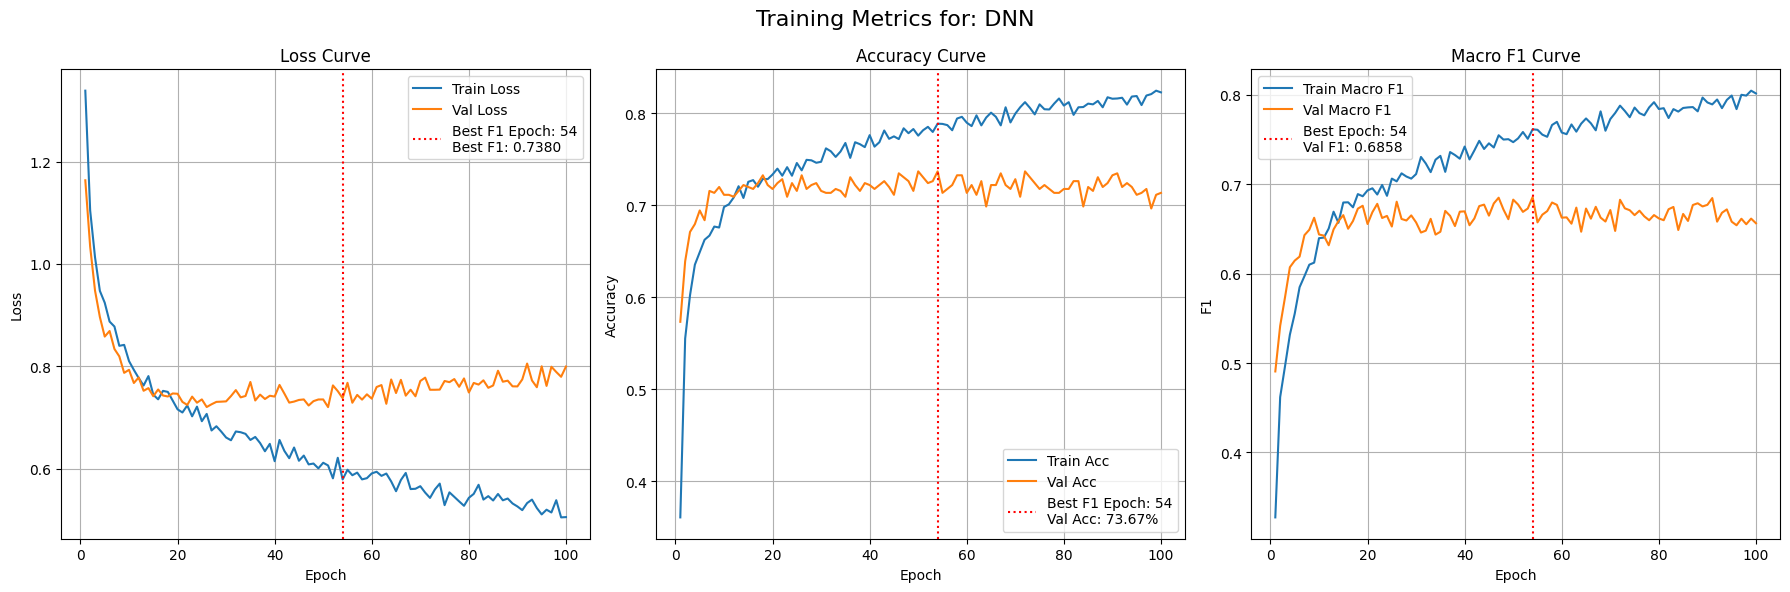

In [20]:
dnn_train_loader = DataLoader(dnn_train, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)
dnn_test_loader = DataLoader(dnn_test, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)
dnn_val_loader = DataLoader(dnn_val, batch_size=8, shuffle=True, pin_memory=True, num_workers = 0)

# loss function and Adam Optimizer
dnn_criterion = nn.CrossEntropyLoss()  # For multi-class classification
dnn_optimizer = optim.Adam(dnn.parameters(), lr=dnn_params["lr"] )  # Adam optimizer

dnn, dnn_train_losses, dnn_val_losses, dnn_train_f1s, dnn_val_f1s = model_train(dnn, dnn_criterion, dnn_optimizer, dnn_train_loader, dnn_val_loader, save_name="DNN", epochs=dnn_params["epochs"], dnn=True)


Matthews correlation coefficient: 0.6239832092175287
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.78      0.89      0.83       190
LIGHT_PROFANITY       0.65      0.57      0.61        94
 HIGH_PROFANITY       0.60      0.50      0.55        60
       VIOLENCE       0.77      0.74      0.76       127

       accuracy                           0.74       471
      macro avg       0.70      0.68      0.69       471
   weighted avg       0.73      0.74      0.73       471



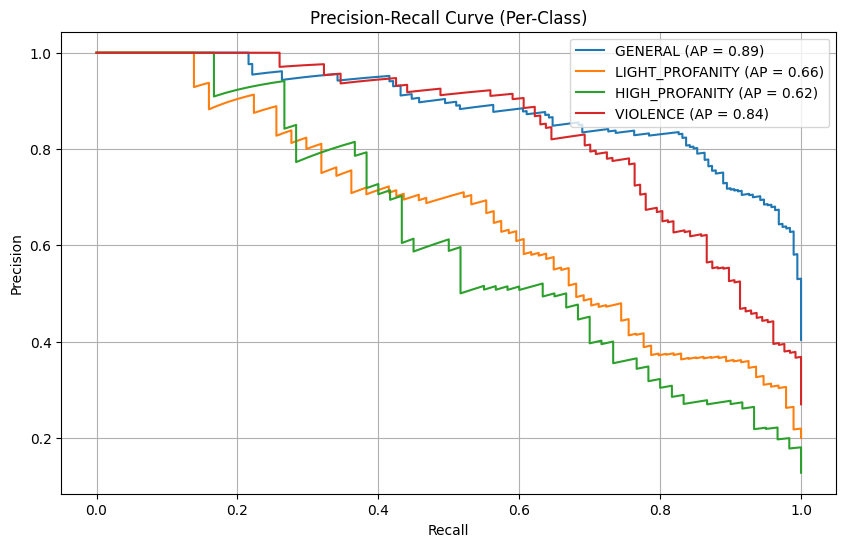

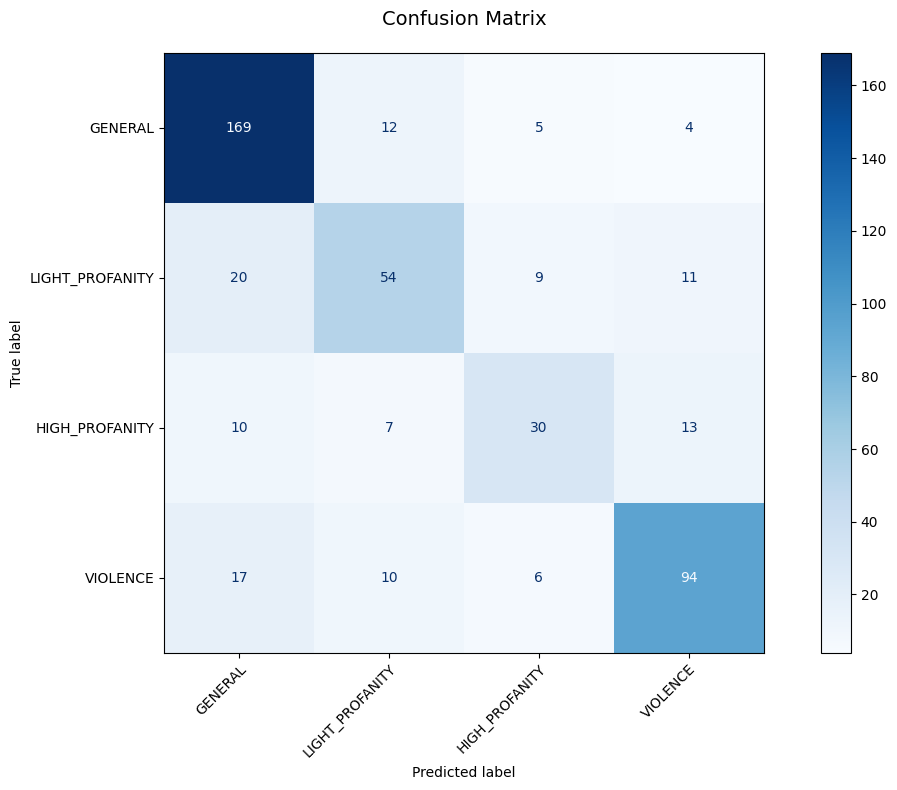

In [21]:
evaluate_model(dnn, dnn_val_loader, label_map, dnn=True)

Matthews correlation coefficient: 0.627523428991038
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.78      0.86      0.82       189
LIGHT_PROFANITY       0.59      0.68      0.63        94
 HIGH_PROFANITY       0.72      0.57      0.64        60
       VIOLENCE       0.81      0.68      0.74       128

       accuracy                           0.74       471
      macro avg       0.73      0.70      0.71       471
   weighted avg       0.74      0.74      0.74       471

PR curve will be saved as DNN_PR.png


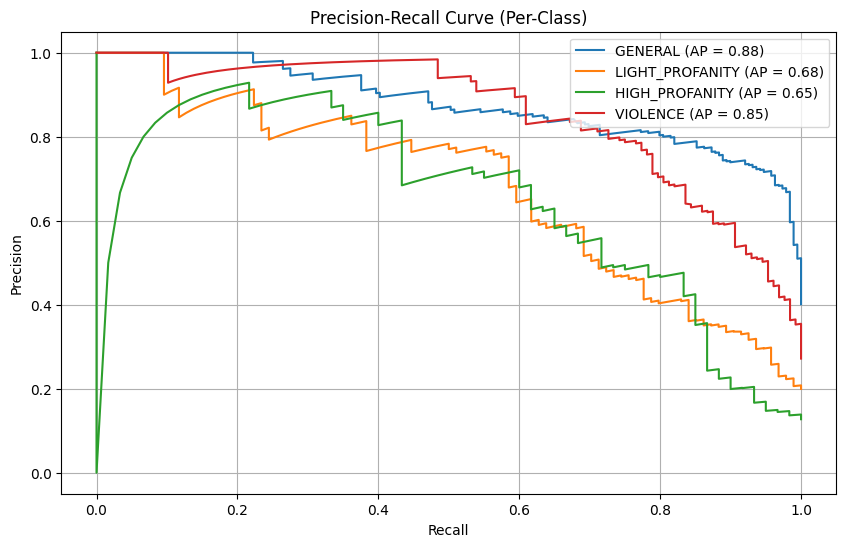

Confusion Matrix will be saved as DNN_cm.png


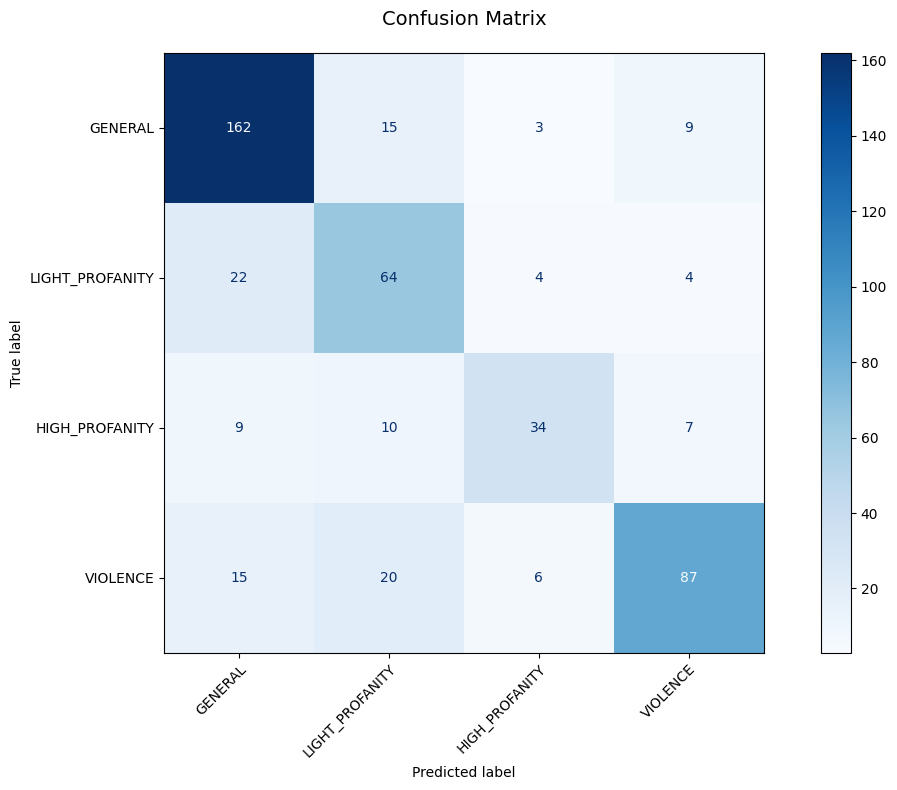

{'0': {'precision': 0.7788461538461539,
  'recall': 0.8571428571428571,
  'f1-score': 0.8161209068010076,
  'support': 189},
 '1': {'precision': 0.5871559633027523,
  'recall': 0.6808510638297872,
  'f1-score': 0.6305418719211823,
  'support': 94},
 '2': {'precision': 0.723404255319149,
  'recall': 0.5666666666666667,
  'f1-score': 0.6355140186915887,
  'support': 60},
 '3': {'precision': 0.8130841121495327,
  'recall': 0.6796875,
  'f1-score': 0.7404255319148936,
  'support': 128},
 'accuracy': 0.7367303609341825,
 'macro avg': {'precision': 0.7256226211543969,
  'recall': 0.6960870219098277,
  'f1-score': 0.705650582332168,
  'support': 471},
 'weighted avg': {'precision': 0.7428314337615094,
  'recall': 0.7367303609341825,
  'f1-score': 0.7355055128504953,
  'support': 471},
 'mcc': 0.627523428991038}

In [22]:
dnn_report = evaluate_model(dnn, dnn_test_loader, label_map, save_name="DNN", dnn=True)
dnn_report

## Warmup Function

In [23]:
def get_linear_warmup_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        # Linear lr increase
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # Linearly decay lr
        return max(
            0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps))
        )
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

## BiLSTM with attention

In [24]:
# Supports both residual and plain lstm
class BiLSTMAttn(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True, lstm_dropout=0, residual=False):
        super().__init__()
        self.lstm = ResLSTM(input_dim, hidden_dim,num_layers=num_layers, batch_first=True, bidirectional=bidirectional) if residual else nn.LSTM(input_dim, hidden_dim,num_layers=num_layers, dropout=lstm_dropout, batch_first=True, bidirectional=bidirectional) 
        self.direction = 2 if bidirectional else 1
        self.ln = nn.LayerNorm(hidden_dim * self.direction)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * self.direction, 1) # since BiLSTM
        self.fc = nn.Linear(hidden_dim * self.direction, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights
        
BiLSTM_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3

}

BiLSTM = BiLSTMAttn(
    input_dim=BiLSTM_params["input_dim"],
    hidden_dim=BiLSTM_params["hidden_dim"],
    num_classes=BiLSTM_params["num_classes"],
    num_layers= BiLSTM_params["num_layers"],
    dropout=BiLSTM_params["dropout"],
    bidirectional = BiLSTM_params["bidirectional"]
).to(device)

# Loss function
BiLSTM_criterion = nn.CrossEntropyLoss(label_smoothing=BiLSTM_params["label_smoothing"])

# Optimizer using unpacking
BiLSTM_optimizer = torch.optim.AdamW(
    BiLSTM.parameters(),
    lr=BiLSTM_params["lr"],
    weight_decay=BiLSTM_params["weight_decay"]
)

total_steps = len(train_loader) * BiLSTM_params["epochs"]
warmup_steps = int(BiLSTM_params["warmup_ratio"] * total_steps)

BiLSTM_scheduler = get_linear_warmup_scheduler(
    BiLSTM_optimizer, warmup_steps=warmup_steps, total_steps=total_steps
 )

print(BiLSTM)
print("\n----------------------------------------------------\n")
print(count_parameters(BiLSTM))

BiLSTMAttn(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

534877


Epoch 1/20 | Train Loss: 1.3334 | Val Loss: 0.9845 | Train F1: 0.3130 | Val F1: 0.4788
Epoch 2/20 | Train Loss: 0.8381 | Val Loss: 0.6900 | Train F1: 0.5748 | Val F1: 0.6746
Epoch 3/20 | Train Loss: 0.6317 | Val Loss: 0.6063 | Train F1: 0.7211 | Val F1: 0.7303
Epoch 4/20 | Train Loss: 0.5150 | Val Loss: 0.5751 | Train F1: 0.7949 | Val F1: 0.7576
Epoch 5/20 | Train Loss: 0.4516 | Val Loss: 0.5741 | Train F1: 0.8191 | Val F1: 0.7652
Epoch 6/20 | Train Loss: 0.4104 | Val Loss: 0.5597 | Train F1: 0.8382 | Val F1: 0.7671
Epoch 7/20 | Train Loss: 0.3679 | Val Loss: 0.5580 | Train F1: 0.8592 | Val F1: 0.7744
Epoch 8/20 | Train Loss: 0.3412 | Val Loss: 0.5552 | Train F1: 0.8694 | Val F1: 0.7895
Epoch 9/20 | Train Loss: 0.3221 | Val Loss: 0.5673 | Train F1: 0.8803 | Val F1: 0.8060
Epoch 10/20 | Train Loss: 0.2821 | Val Loss: 0.5955 | Train F1: 0.8945 | Val F1: 0.7957
Epoch 11/20 | Train Loss: 0.2651 | Val Loss: 0.5638 | Train F1: 0.9013 | Val F1: 0.7844
Epoch 12/20 | Train Loss: 0.2474 | Val Lo

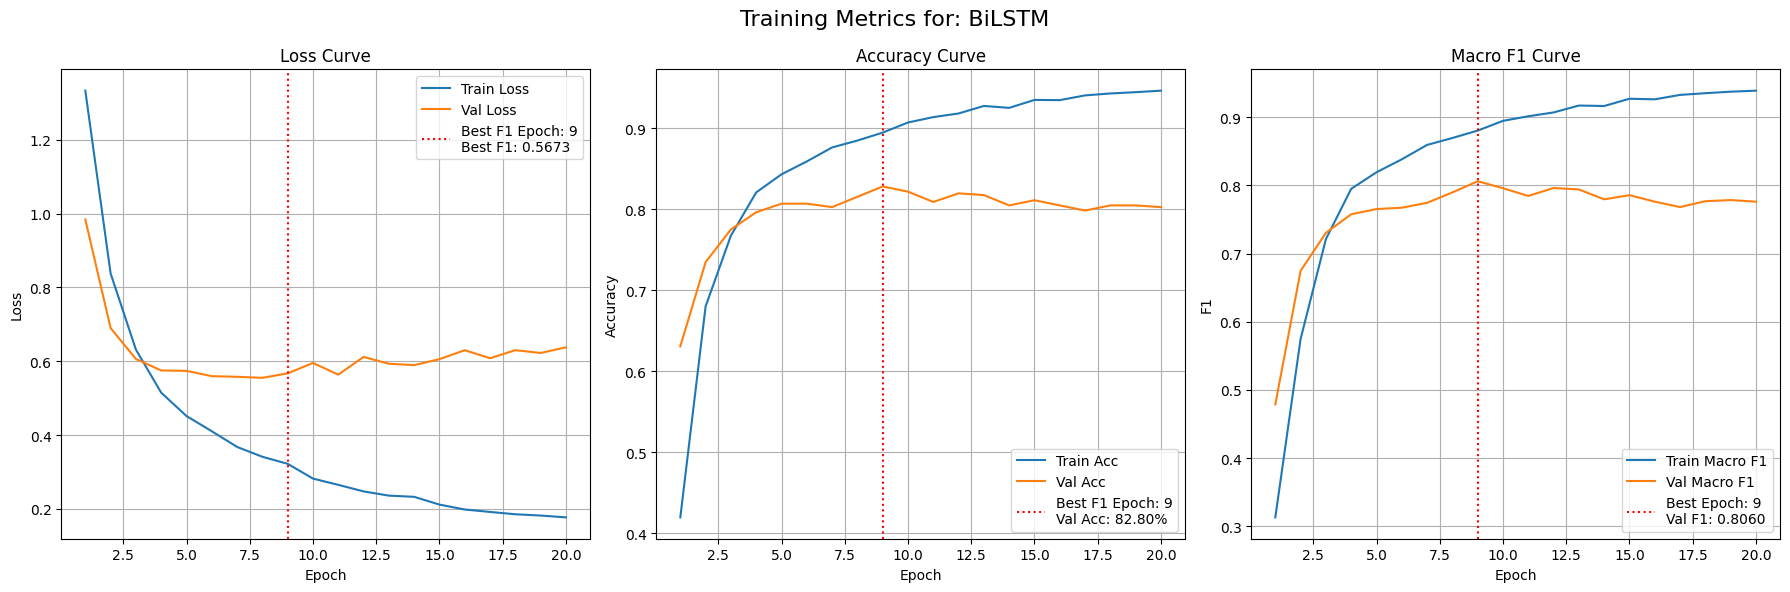

Matthews correlation coefficient: 0.7571732062503296
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.93      0.89       190
LIGHT_PROFANITY       0.73      0.73      0.73        94
 HIGH_PROFANITY       0.77      0.78      0.78        60
       VIOLENCE       0.88      0.77      0.82       127

       accuracy                           0.83       471
      macro avg       0.81      0.80      0.81       471
   weighted avg       0.83      0.83      0.83       471



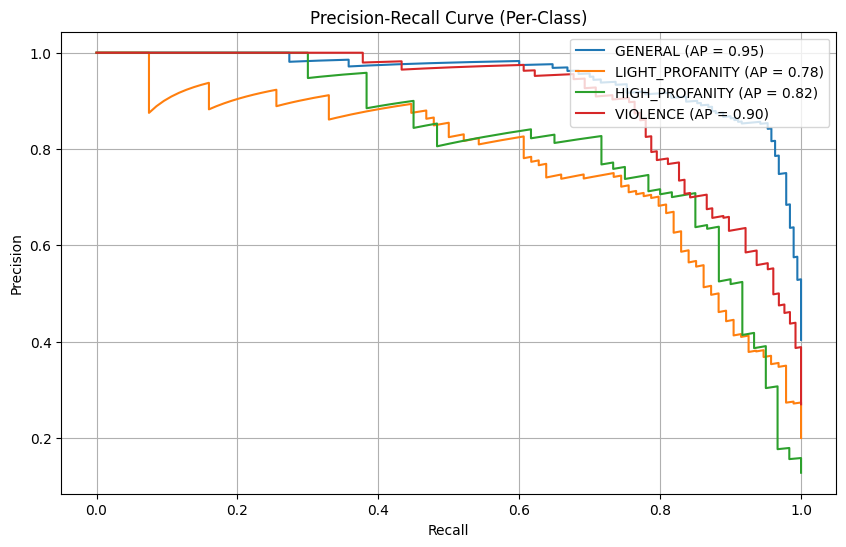

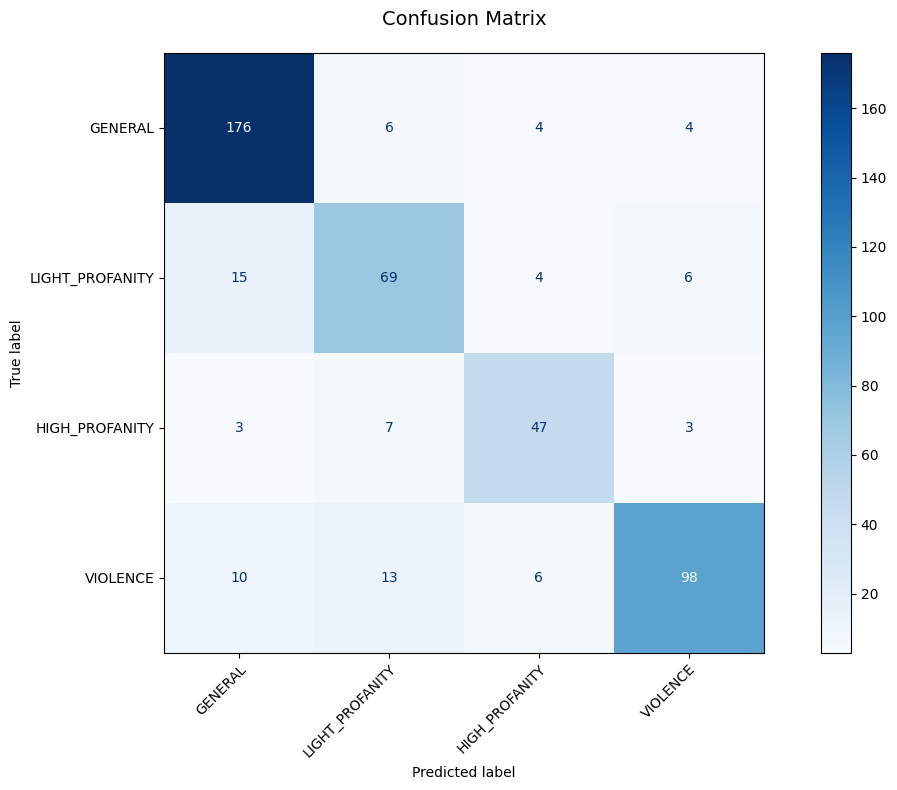

In [25]:
BiLSTM, BiLSTM_train_losses, BiLSTM_val_losses, BiLSTM_train_f1s, BiLSTM_val_f1s = model_train(BiLSTM, BiLSTM_criterion, BiLSTM_optimizer, train_loader, val_loader, scheduler=BiLSTM_scheduler, save_name="BiLSTM", epochs=BiLSTM_params["epochs"])
evaluate_model(BiLSTM, val_loader, label_map)

Matthews correlation coefficient: 0.7384766500185308
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.88      0.87       189
LIGHT_PROFANITY       0.69      0.82      0.75        94
 HIGH_PROFANITY       0.79      0.75      0.77        60
       VIOLENCE       0.88      0.73      0.80       128

       accuracy                           0.81       471
      macro avg       0.80      0.80      0.80       471
   weighted avg       0.82      0.81      0.81       471

PR curve will be saved as BiLSTM_PR.png


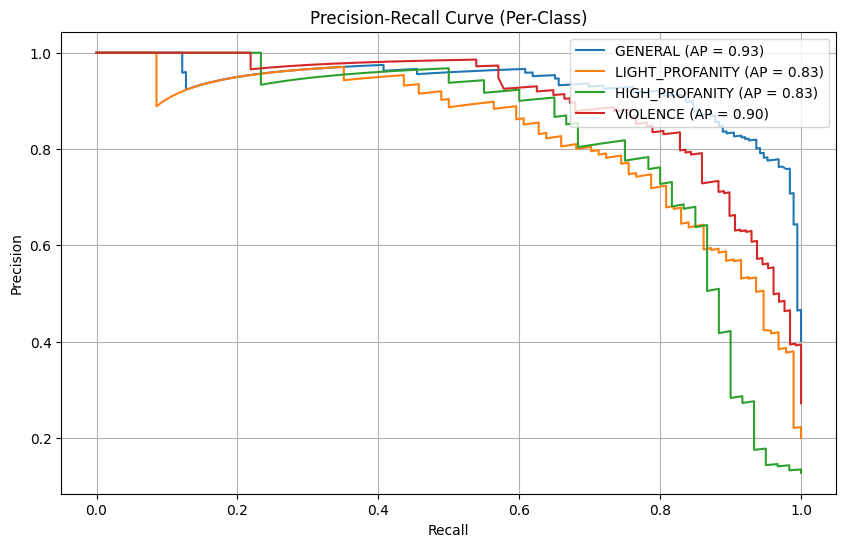

Confusion Matrix will be saved as BiLSTM_cm.png


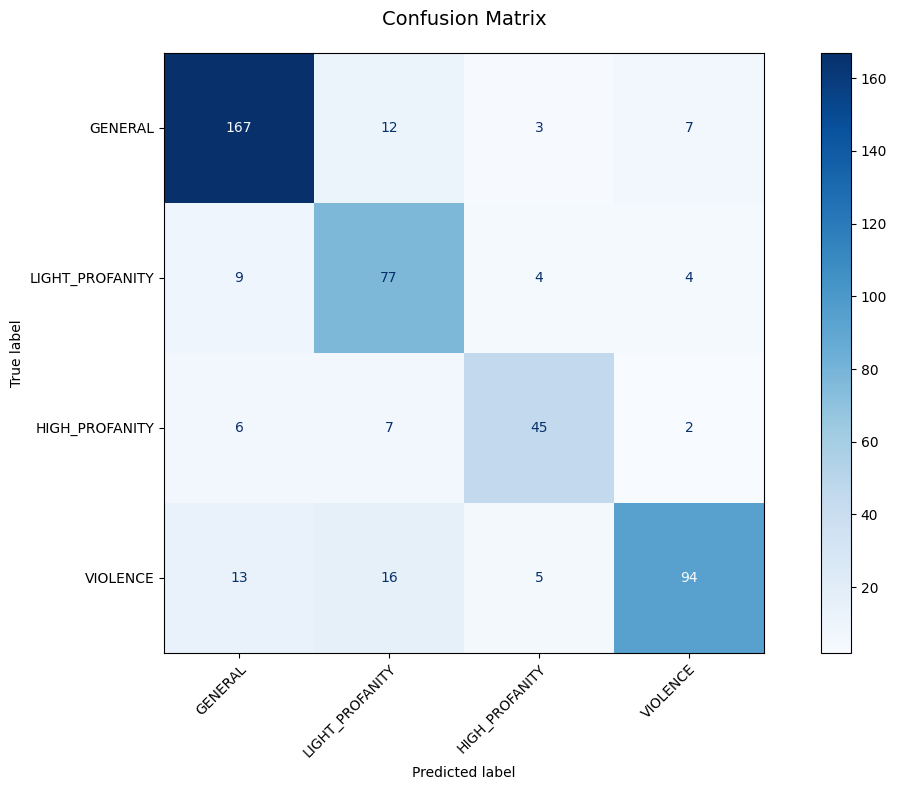

In [26]:
BiLSTM_report = evaluate_model(BiLSTM, test_loader, label_map, save_name="BiLSTM")

## Residual BiLSTM with Attention

In [27]:
print(BiLSTM)
print(type(BiLSTM))


BiLSTMAttn(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)
<class '__main__.BiLSTMAttn'>


In [28]:
ResBiLSTM_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 5e-5,
    "weight_decay" : 5e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM = BiLSTMAttn(
    input_dim=ResBiLSTM_params["input_dim"],
    hidden_dim=ResBiLSTM_params["hidden_dim"],
    num_classes=ResBiLSTM_params["num_classes"],
    num_layers= ResBiLSTM_params["num_layers"],
    dropout=ResBiLSTM_params["dropout"],
    lstm_dropout=ResBiLSTM_params["lstm_dropout"],
    bidirectional=ResBiLSTM_params["bidirectional"],
    residual=True
).to(device)

# Loss function
ResBiLSTM_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_optimizer = torch.optim.AdamW(
    ResBiLSTM.parameters(),
    lr=ResBiLSTM_params["lr"],
    weight_decay=ResBiLSTM_params["weight_decay"]
)

res_total_steps = len(train_loader) * ResBiLSTM_params["epochs"]
res_warmup_steps = int(ResBiLSTM_params["warmup_ratio"] * res_total_steps)

ResBiLSTM_scheduler = get_linear_warmup_scheduler(
    ResBiLSTM_optimizer, warmup_steps=res_warmup_steps, total_steps=res_total_steps
)

res_train_loader = DataLoader(finetuned_train, batch_size=ResBiLSTM_params["train_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
res_test_loader = DataLoader(finetuned_test, batch_size=ResBiLSTM_params["test_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
res_val_loader = DataLoader(finetuned_val, batch_size=ResBiLSTM_params["val_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)

print(ResBiLSTM)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM))

BiLSTMAttn(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell(
          (ln_ry): RecursiveScriptModule(original_name=LayerNorm)
          (ln_res): RecursiveScriptModule(original_name=LayerNorm)
        )
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell(
          (ln_ry): RecursiveScriptModule(original_name=LayerNorm)
          (ln_res): RecursiveScriptModule(original_name=LayerNorm)
        )
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

623677


Epoch 1/20 | Train Loss: 1.3953 | Val Loss: 1.1372 | Train F1: 0.2746 | Val F1: 0.3427
Epoch 2/20 | Train Loss: 1.0073 | Val Loss: 0.8379 | Train F1: 0.4629 | Val F1: 0.6225
Epoch 3/20 | Train Loss: 0.7533 | Val Loss: 0.6673 | Train F1: 0.6416 | Val F1: 0.6824
Epoch 4/20 | Train Loss: 0.6163 | Val Loss: 0.6070 | Train F1: 0.7308 | Val F1: 0.7263
Epoch 5/20 | Train Loss: 0.5351 | Val Loss: 0.5767 | Train F1: 0.7698 | Val F1: 0.7356
Epoch 6/20 | Train Loss: 0.4793 | Val Loss: 0.5781 | Train F1: 0.8000 | Val F1: 0.7267
Epoch 7/20 | Train Loss: 0.4442 | Val Loss: 0.5396 | Train F1: 0.8142 | Val F1: 0.7702
Epoch 8/20 | Train Loss: 0.4047 | Val Loss: 0.5422 | Train F1: 0.8328 | Val F1: 0.7719
Epoch 9/20 | Train Loss: 0.3790 | Val Loss: 0.5545 | Train F1: 0.8455 | Val F1: 0.7777
Epoch 10/20 | Train Loss: 0.3577 | Val Loss: 0.5404 | Train F1: 0.8556 | Val F1: 0.7990
Epoch 11/20 | Train Loss: 0.3234 | Val Loss: 0.5510 | Train F1: 0.8745 | Val F1: 0.7996
Epoch 12/20 | Train Loss: 0.3214 | Val Lo

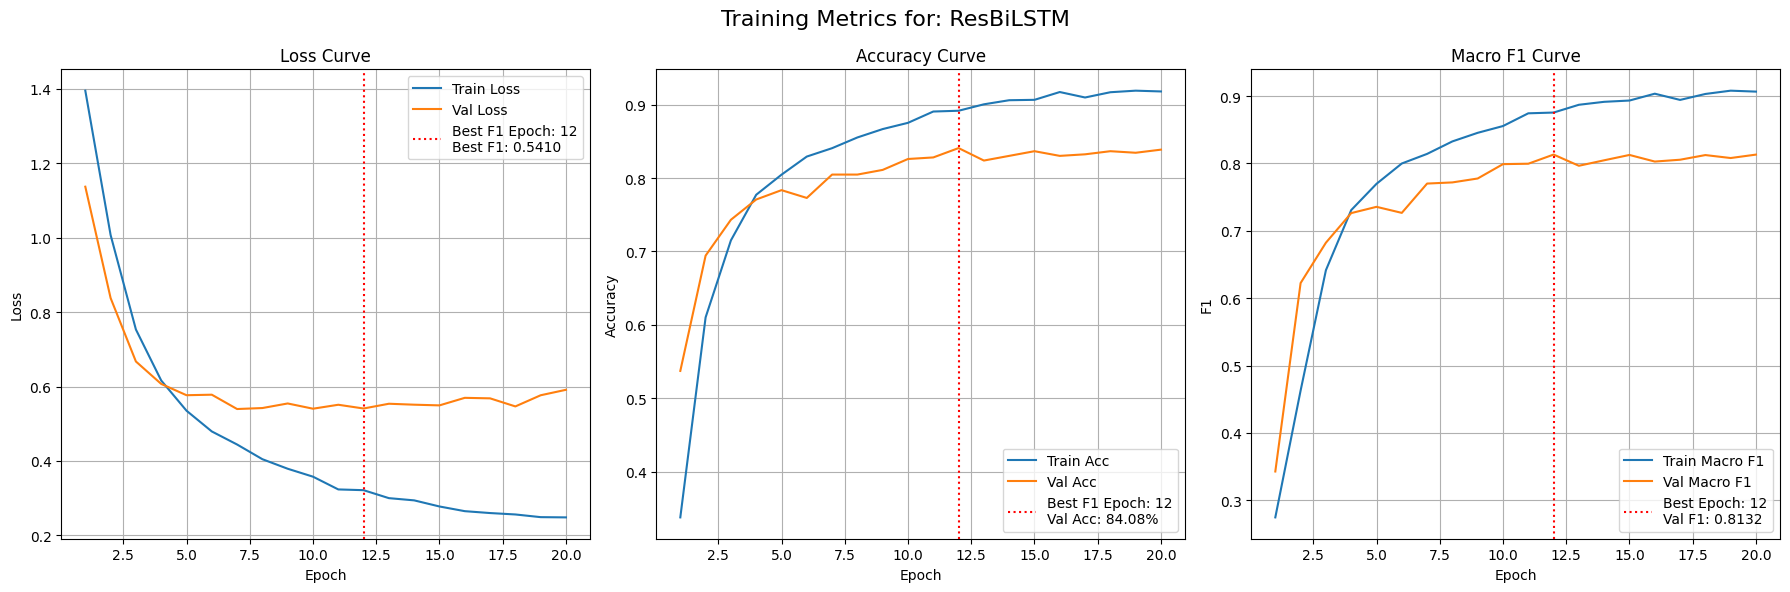

In [29]:
ResBiLSTM, ResBiLSTM_train_losses, ResBiLSTM_val_losses, ResBiLSTM_train_f1s, ResBiLSTM_val_f1s = model_train(ResBiLSTM, ResBiLSTM_criterion, ResBiLSTM_optimizer, res_train_loader, res_val_loader, scheduler=ResBiLSTM_scheduler, save_name="ResBiLSTM", epochs=ResBiLSTM_params["epochs"])


Matthews correlation coefficient: 0.7748730761630033
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.90      0.95      0.92       190
LIGHT_PROFANITY       0.79      0.63      0.70        94
 HIGH_PROFANITY       0.79      0.82      0.80        60
       VIOLENCE       0.81      0.85      0.83       127

       accuracy                           0.84       471
      macro avg       0.82      0.81      0.81       471
   weighted avg       0.84      0.84      0.84       471



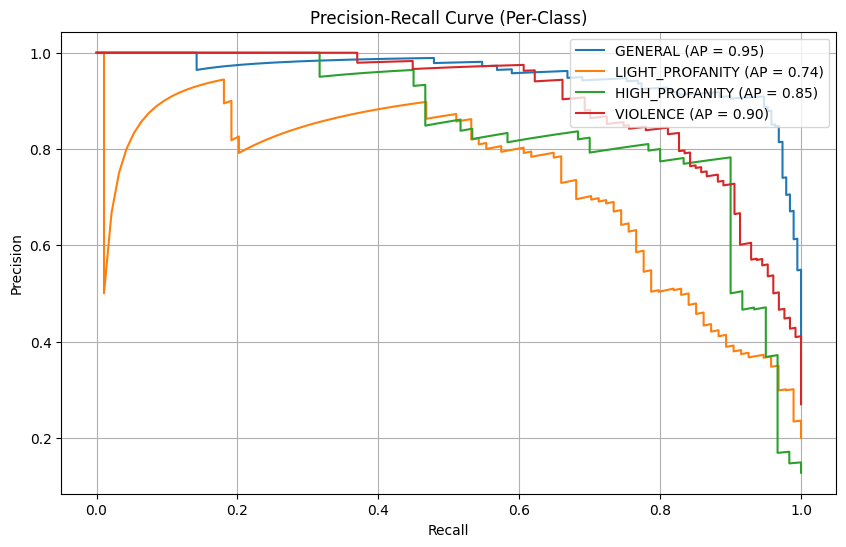

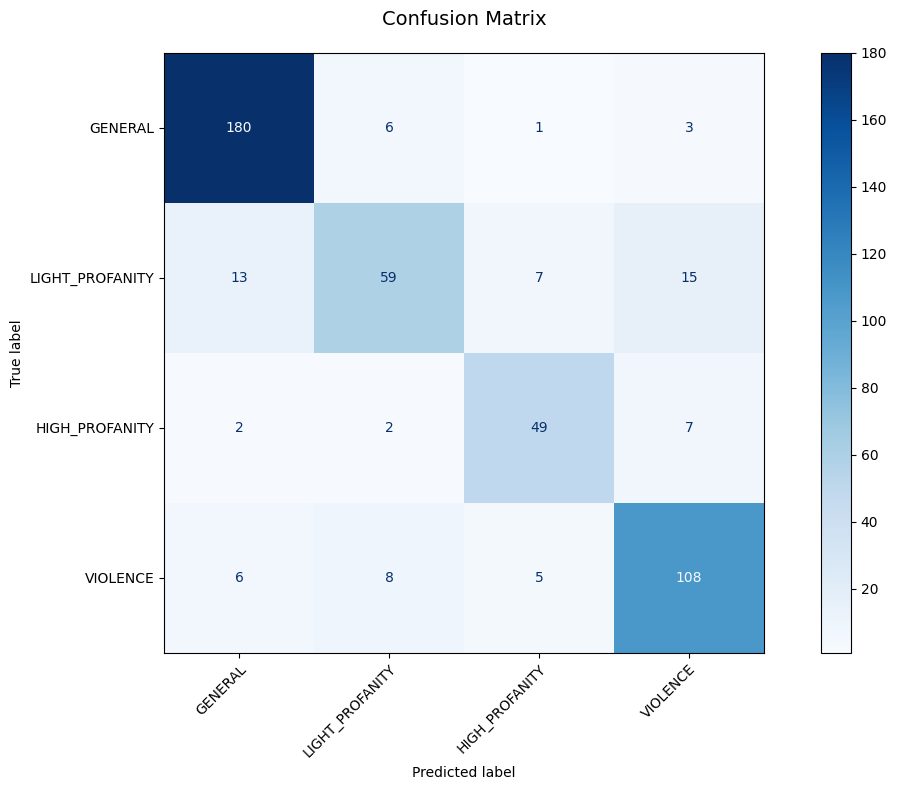

In [30]:
evaluate_model(ResBiLSTM, val_loader, label_map)

Matthews correlation coefficient: 0.7354618149140602
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.86      0.90      0.88       189
LIGHT_PROFANITY       0.73      0.69      0.71        94
 HIGH_PROFANITY       0.76      0.75      0.76        60
       VIOLENCE       0.82      0.80      0.81       128

       accuracy                           0.81       471
      macro avg       0.79      0.79      0.79       471
   weighted avg       0.81      0.81      0.81       471

PR curve will be saved as ResBiLSTM_PR.png


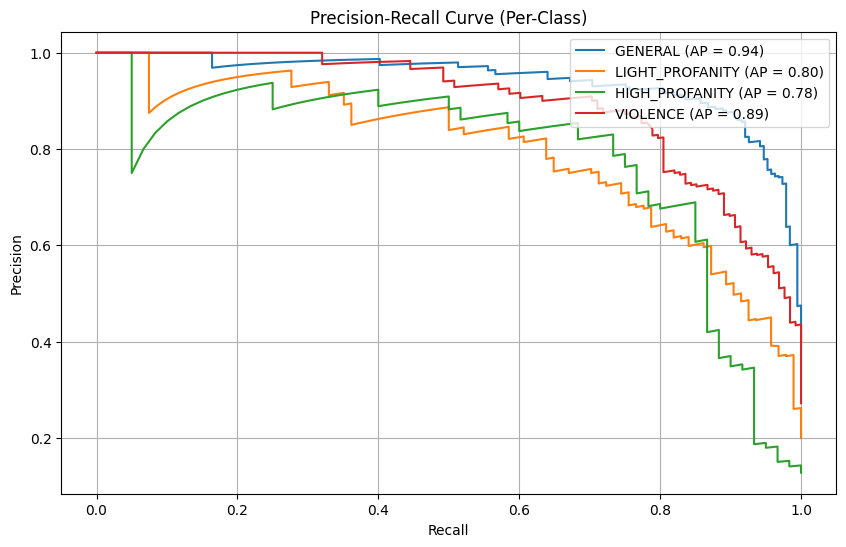

Confusion Matrix will be saved as ResBiLSTM_cm.png


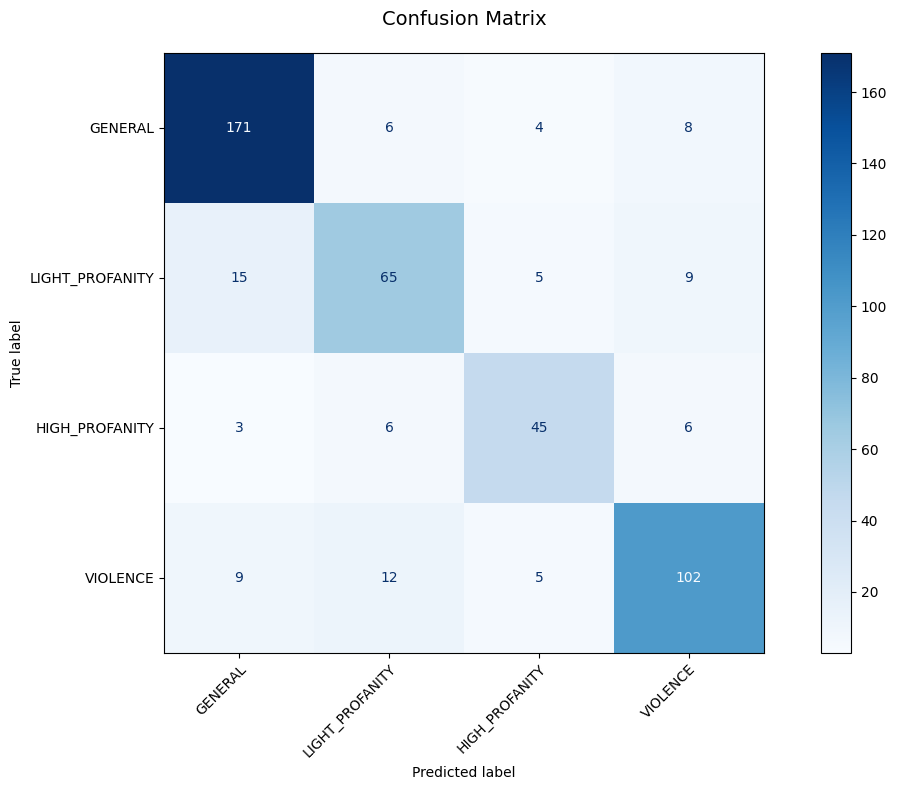

In [31]:
ResBiLSTM_report = evaluate_model(ResBiLSTM, test_loader, label_map, save_name="ResBiLSTM")

## Bilstm with word2vec input as post attention

In [32]:
# First we need the dataset to contain mean of word2vec embeddings, sequence embeddings, mask 
class ModifiedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        item = self.original_dataset[idx]
        
        features, mask, label = item
        
        if mask.dtype != torch.bool:
            mask = mask.bool() 

        filtered_features = features[mask]
        mean_features = torch.mean(filtered_features, dim=0)
            
        return (features, mean_features, mask, label)

train2 = ModifiedDataset(finetuned_train)
test2 = ModifiedDataset(finetuned_test)
val2 = ModifiedDataset(finetuned_val)

In [33]:
# Supports both residual and plain lstm
class BiLSTMAttn2(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,num_layers=num_layers, batch_first=True, bidirectional=bidirectional) 
        self.direction = 2 if bidirectional else 1
        self.ln = nn.LayerNorm(hidden_dim * self.direction)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim * self.direction, 1) # since BiLSTM
        self.proj = nn.Linear(input_dim, hidden_dim * self.direction)
        self.fc1 = nn.Linear(hidden_dim * self.direction, hidden_dim * self.direction)
        self.fc2 = nn.Linear(hidden_dim * self.direction, num_classes)

    def forward(self, x, x_mean, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before adding

        # Handling x_mean to shape (B, 2H)
        x_mean_proj = self.proj(x_mean)

        # Adding two tensors
        fused = context + x_mean_proj 
        fused = self.fc1(fused)
        fused = self.ln(fused)
        fused = self.dropout(fused)
        
        logits = self.fc2(fused)  # (B, num_classes)

        return logits, attn_weights

BiLSTM2_params = {
    "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.5,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3

}

BiLSTM2 = BiLSTMAttn2(
    input_dim=BiLSTM2_params["input_dim"],
    hidden_dim=BiLSTM2_params["hidden_dim"],
    num_classes=BiLSTM2_params["num_classes"],
    num_layers= BiLSTM2_params["num_layers"],
    dropout=BiLSTM2_params["dropout"],
    bidirectional=BiLSTM2_params["bidirectional"],
).to(device)

# Loss function
BiLSTM2_criterion = nn.CrossEntropyLoss(label_smoothing=BiLSTM2_params["label_smoothing"])

# Optimizer using unpacking
BiLSTM2_optimizer = torch.optim.AdamW(
    BiLSTM2.parameters(),
    lr=BiLSTM2_params["lr"],
    weight_decay=BiLSTM2_params["weight_decay"]
)

res_total_steps = len(train_loader) * BiLSTM2_params["epochs"]
res_warmup_steps = int(BiLSTM2_params["warmup_ratio"] * res_total_steps)

BiLSTM2_scheduler = get_linear_warmup_scheduler(
    BiLSTM2_optimizer, warmup_steps=res_warmup_steps, total_steps=res_total_steps
)

train_loader2 = DataLoader(train2, batch_size=BiLSTM2_params["train_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
test_loader2 = DataLoader(test2, batch_size=BiLSTM2_params["test_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)
val_loader2 = DataLoader(val2, batch_size=BiLSTM2_params["val_batch_size"], shuffle=True, pin_memory=True, num_workers = 0)

print(BiLSTM2)
print("\n----------------------------------------------------\n")
print(count_parameters(BiLSTM2))

BiLSTMAttn2(
  (lstm): LSTM(300, 148, batch_first=True, bidirectional=True)
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (proj): Linear(in_features=300, out_features=296, bias=True)
  (fc1): Linear(in_features=296, out_features=296, bias=True)
  (fc2): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

711885


Epoch 1/20 | Train Loss: 1.2878 | Val Loss: 0.8955 | Train F1: 0.3517 | Val F1: 0.5196
Epoch 2/20 | Train Loss: 0.8290 | Val Loss: 0.7097 | Train F1: 0.5989 | Val F1: 0.7111
Epoch 3/20 | Train Loss: 0.6374 | Val Loss: 0.6660 | Train F1: 0.7220 | Val F1: 0.7311
Epoch 4/20 | Train Loss: 0.5435 | Val Loss: 0.5896 | Train F1: 0.7733 | Val F1: 0.7676
Epoch 5/20 | Train Loss: 0.4721 | Val Loss: 0.6058 | Train F1: 0.8074 | Val F1: 0.7406
Epoch 6/20 | Train Loss: 0.4349 | Val Loss: 0.6409 | Train F1: 0.8196 | Val F1: 0.7492
Epoch 7/20 | Train Loss: 0.3902 | Val Loss: 0.6001 | Train F1: 0.8467 | Val F1: 0.7609
Epoch 8/20 | Train Loss: 0.3580 | Val Loss: 0.6161 | Train F1: 0.8568 | Val F1: 0.7576
Epoch 9/20 | Train Loss: 0.3353 | Val Loss: 0.6448 | Train F1: 0.8711 | Val F1: 0.7724
Epoch 10/20 | Train Loss: 0.2998 | Val Loss: 0.6536 | Train F1: 0.8820 | Val F1: 0.7672
Epoch 11/20 | Train Loss: 0.2716 | Val Loss: 0.6366 | Train F1: 0.8952 | Val F1: 0.7824
Epoch 12/20 | Train Loss: 0.2567 | Val Lo

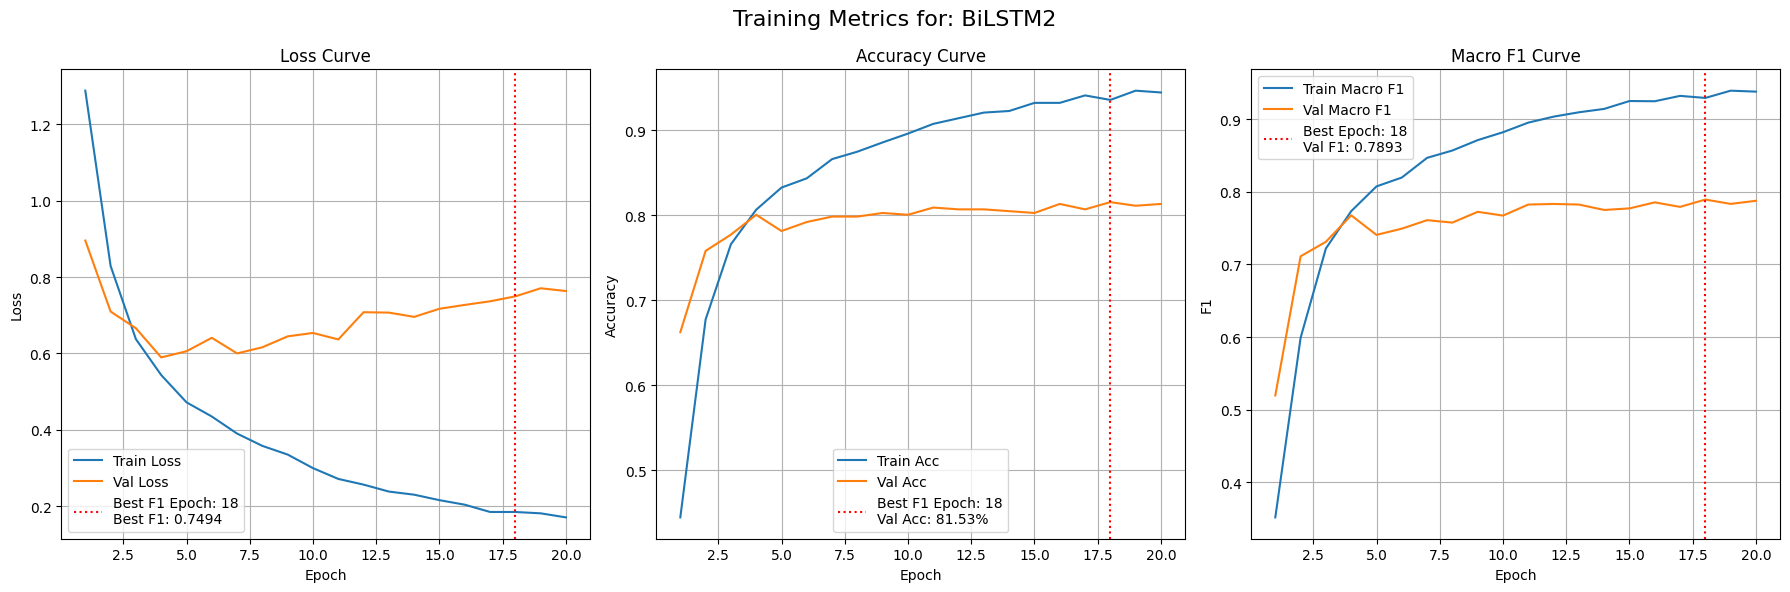

In [34]:
BiLSTM2, BiLSTM2_train_losses, BiLSTM2_val_losses, BiLSTM2_train_f1s, BiLSTM2_val_f1s = model_train(BiLSTM2, BiLSTM2_criterion, BiLSTM2_optimizer, train_loader2, val_loader2, scheduler=BiLSTM2_scheduler, save_name="BiLSTM2", epochs=BiLSTM2_params["epochs"], model2=True)


Matthews correlation coefficient: 0.7371743907073942
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.84      0.93      0.88       190
LIGHT_PROFANITY       0.77      0.71      0.74        94
 HIGH_PROFANITY       0.80      0.68      0.74        60
       VIOLENCE       0.81      0.78      0.80       127

       accuracy                           0.82       471
      macro avg       0.81      0.78      0.79       471
   weighted avg       0.81      0.82      0.81       471



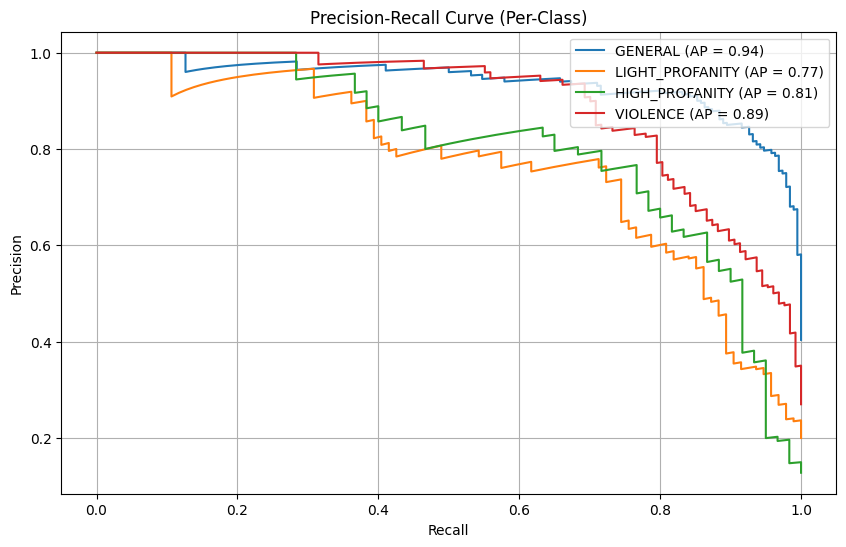

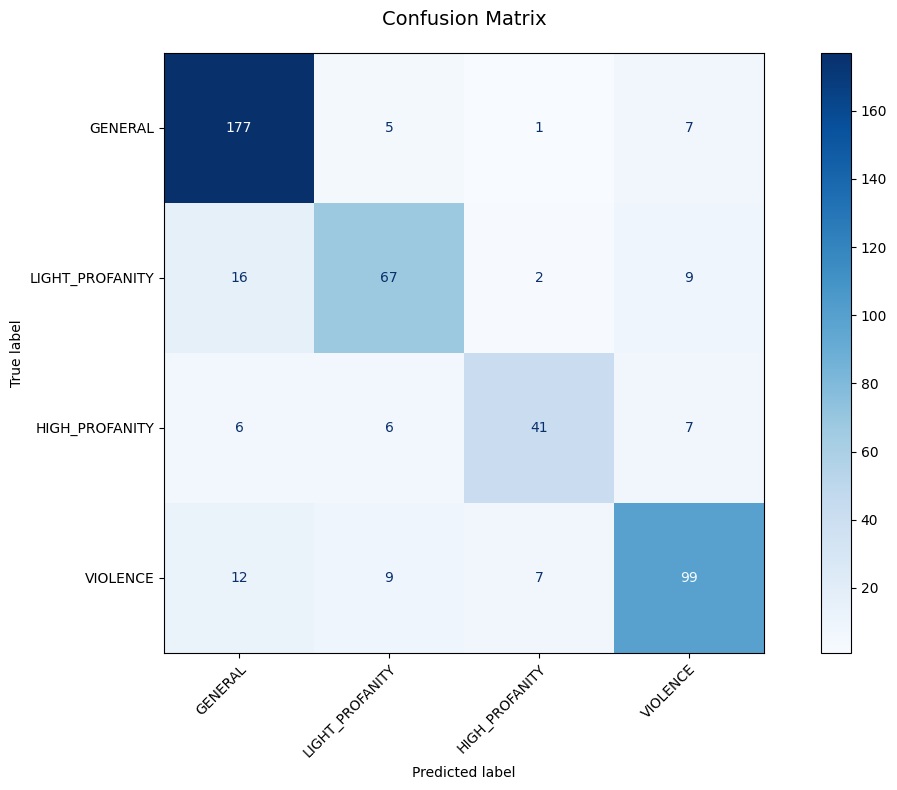

In [35]:
evaluate_model(BiLSTM2, val_loader2, label_map, model2=True)

Matthews correlation coefficient: 0.7453290550198992
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.85      0.91      0.88       189
LIGHT_PROFANITY       0.70      0.76      0.72        94
 HIGH_PROFANITY       0.82      0.75      0.78        60
       VIOLENCE       0.88      0.77      0.82       128

       accuracy                           0.82       471
      macro avg       0.81      0.80      0.80       471
   weighted avg       0.82      0.82      0.82       471

PR curve will be saved as BiLSTM2_PR.png


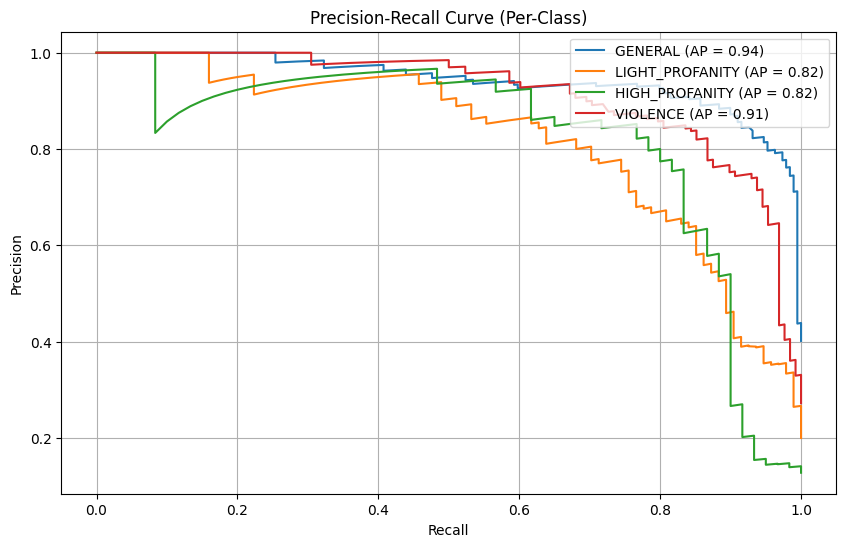

Confusion Matrix will be saved as BiLSTM2_cm.png


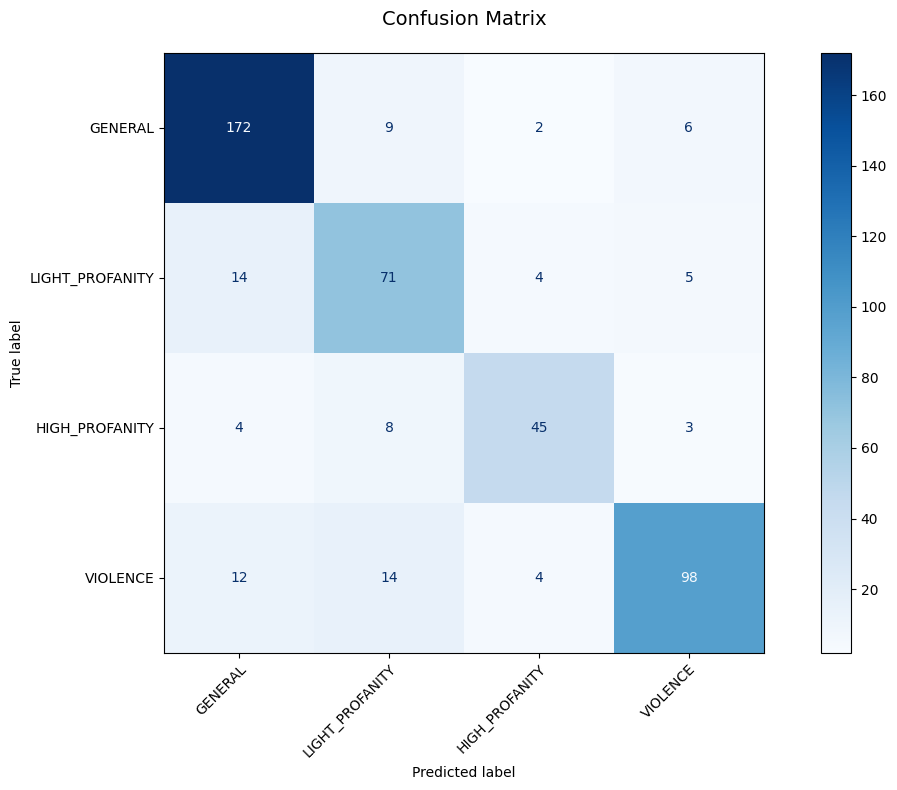

In [36]:
BiLSTM2_report = evaluate_model(BiLSTM2, test_loader2, label_map, save_name="BiLSTM2", model2=True)

## Previous residual LSTM

In [37]:
# Previous Residual LSTM implementation 
shutil.copy(Path("/kaggle/input/pretrained-fasttext/lstm_prev.py"), Path("./"))

from lstm_prev import ResLSTM as ResLSTM_previous
from torch.optim.lr_scheduler import CosineAnnealingLR

In [38]:
class ResBiLSTMAttn_prev(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.lstm = ResLSTM_previous(input_dim, hidden_dim,num_layers, batch_first=True, bidirectional = bidirectional)
        self.ln = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(hidden_dim*2 , 1)
        self.fc = nn.Linear(hidden_dim *2, num_classes)

    def forward(self, x, mask):
        lstm_out, _ = self.lstm(x)  # (Batch, SequenceLength, 2 * Hidden Dim)
        lstm_out = self.ln(lstm_out)  # Normalize
        lstm_out = self.dropout(lstm_out)  # Dropout

        # Attention scores
        scores = self.attn(lstm_out).squeeze(-1)  # (B, L)

        # Mask padding positions
        scores = scores.masked_fill(~mask, float('-inf'))  # invalid positions → -inf

        attn_weights = torch.softmax(scores, dim=1)  # (B, L)
        attn_weights = attn_weights.unsqueeze(-1)   # (B, L, 1)

        # Weighted sum
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2H)
        context = self.ln(context) # normalize before FC
        logits = self.fc(context)  # (B, num_classes)

        return logits, attn_weights

In [39]:
ResBiLSTM_prev_params = {
   "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-4,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.4,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM_prev = ResBiLSTMAttn_prev(
    input_dim=ResBiLSTM_prev_params["input_dim"],
    hidden_dim=ResBiLSTM_prev_params["hidden_dim"],
    num_classes=ResBiLSTM_prev_params["num_classes"],
    num_layers= ResBiLSTM_prev_params["num_layers"],
    dropout=ResBiLSTM_prev_params["dropout"],
    bidirectional=ResBiLSTM_prev_params["bidirectional"],
).to(device)

# Loss function
ResBiLSTM_prev_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_prev_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_prev_optimizer = torch.optim.AdamW(
    ResBiLSTM_prev.parameters(),
    lr=ResBiLSTM_prev_params["lr"],
    weight_decay=ResBiLSTM_prev_params["weight_decay"]
)


ResBiLSTM_prev_scheduler = CosineAnnealingLR(ResBiLSTM_prev_optimizer, T_max=len(train_loader) * ResBiLSTM_prev_params["epochs"])

print(ResBiLSTM_prev)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM_prev))


ResBiLSTMAttn_prev(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

666893


Epoch 1/20 | Train Loss: 1.4984 | Val Loss: 1.4596 | Train F1: 0.2112 | Val F1: 0.2384
Epoch 2/20 | Train Loss: 1.4988 | Val Loss: 1.4628 | Train F1: 0.2230 | Val F1: 0.2324
Epoch 3/20 | Train Loss: 1.4972 | Val Loss: 1.4690 | Train F1: 0.2329 | Val F1: 0.2174
Epoch 4/20 | Train Loss: 1.4952 | Val Loss: 1.4696 | Train F1: 0.2333 | Val F1: 0.2372
Epoch 5/20 | Train Loss: 1.4910 | Val Loss: 1.4762 | Train F1: 0.2343 | Val F1: 0.2199
Epoch 6/20 | Train Loss: 1.4906 | Val Loss: 1.4101 | Train F1: 0.2245 | Val F1: 0.2746
Epoch 7/20 | Train Loss: 1.5004 | Val Loss: 1.4623 | Train F1: 0.2259 | Val F1: 0.2000
Epoch 8/20 | Train Loss: 1.4953 | Val Loss: 1.4630 | Train F1: 0.2236 | Val F1: 0.2367
Epoch 9/20 | Train Loss: 1.5004 | Val Loss: 1.4401 | Train F1: 0.2255 | Val F1: 0.2096
Epoch 10/20 | Train Loss: 1.5131 | Val Loss: 1.5605 | Train F1: 0.2147 | Val F1: 0.2308
Epoch 11/20 | Train Loss: 1.4999 | Val Loss: 1.4237 | Train F1: 0.2288 | Val F1: 0.2766
Epoch 12/20 | Train Loss: 1.5032 | Val Lo

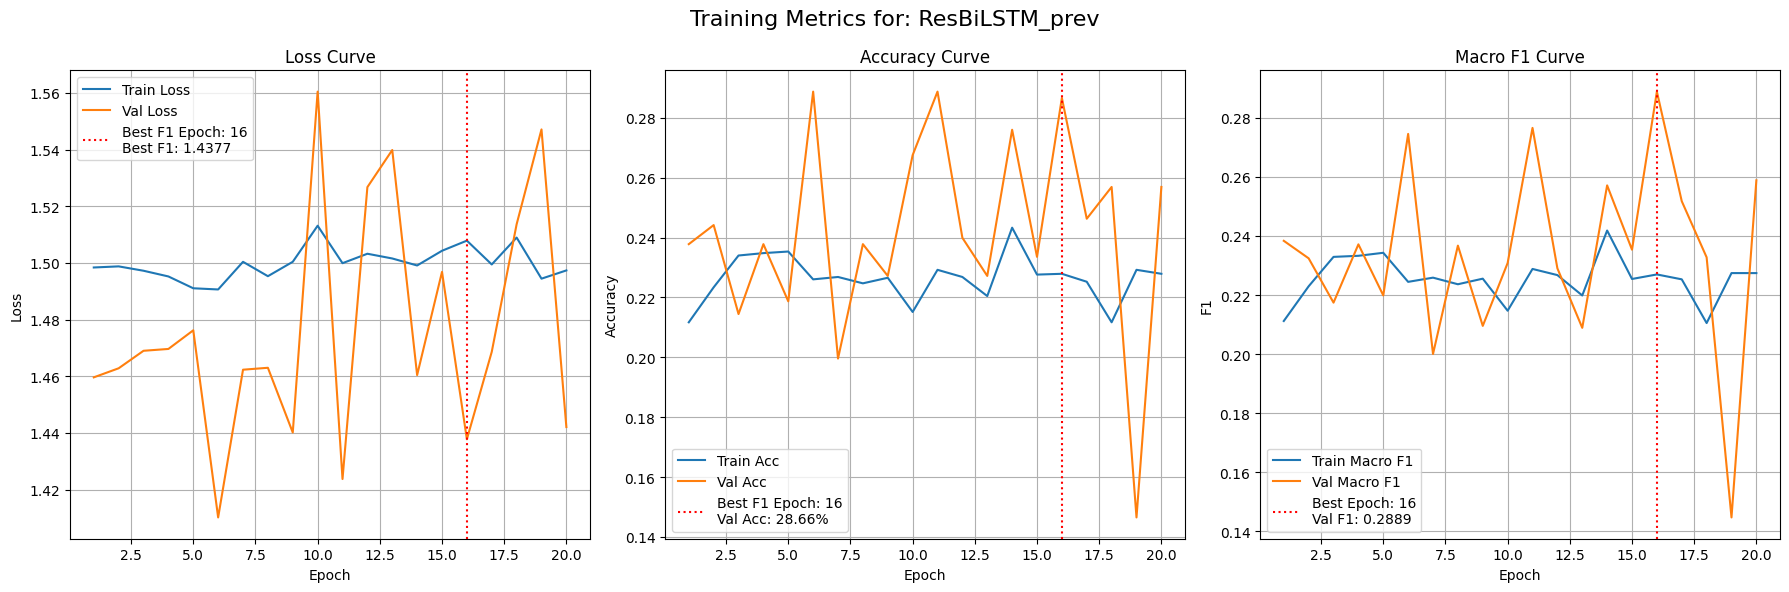

Matthews correlation coefficient: 0.1075460876701901
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.55      0.21      0.30       190
LIGHT_PROFANITY       0.25      0.33      0.29        94
 HIGH_PROFANITY       0.15      0.50      0.24        60
       VIOLENCE       0.44      0.28      0.34       127

       accuracy                           0.29       471
      macro avg       0.35      0.33      0.29       471
   weighted avg       0.41      0.29      0.30       471



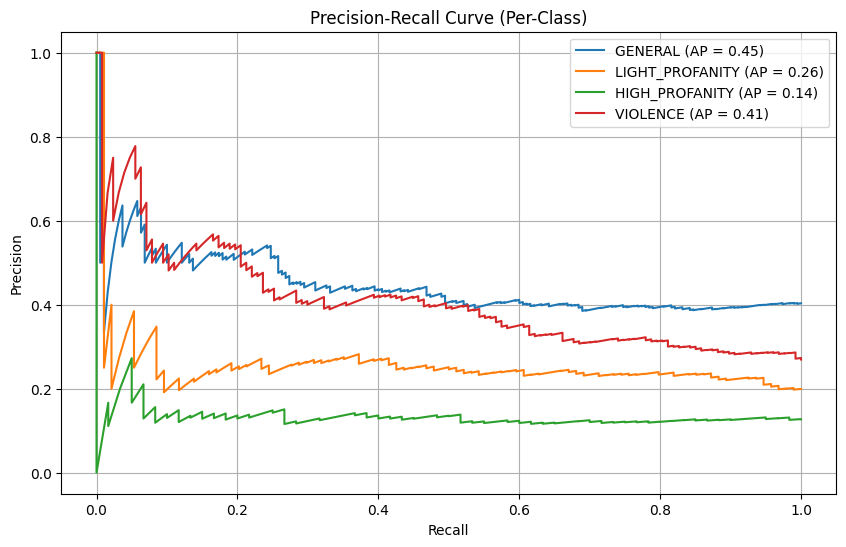

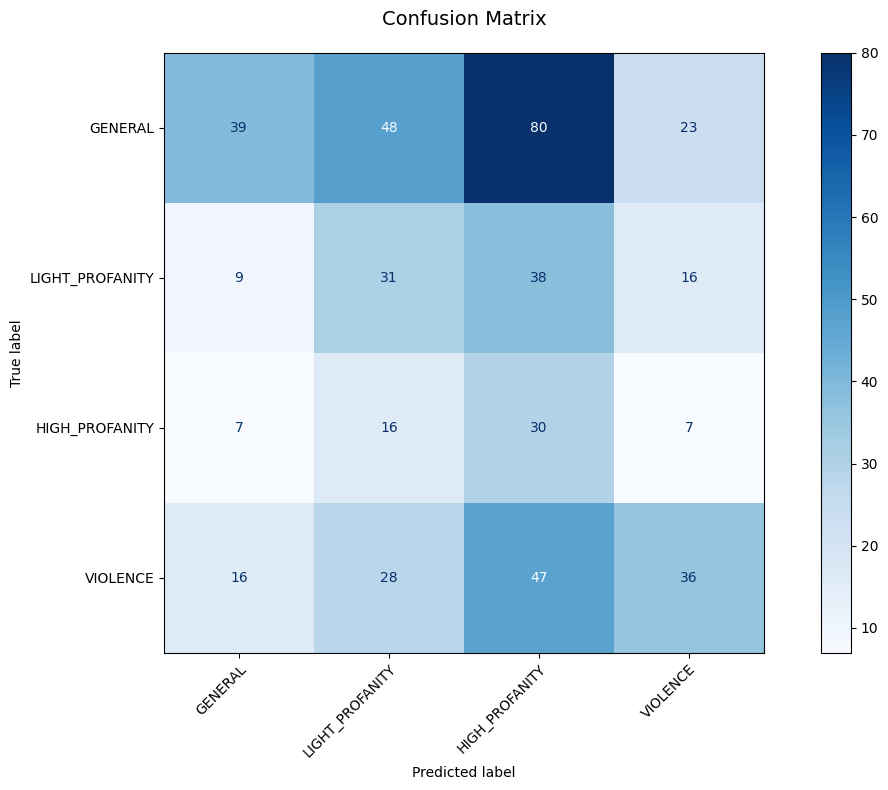

In [40]:
ResBiLSTM_prev, ResBiLSTM_prev_train_losses, ResBiLSTM_prev_val_losses, ResBiLSTM_prev_train_f1s, ResBiLSTM_prev_val_f1s = model_train(ResBiLSTM_prev, ResBiLSTM_prev_criterion, ResBiLSTM_prev_optimizer, train_loader, val_loader, scheduler=ResBiLSTM_prev_scheduler, save_name="ResBiLSTM_prev", epochs=ResBiLSTM_prev_params["epochs"])
evaluate_model(ResBiLSTM_prev, val_loader, label_map)

Matthews correlation coefficient: 0.05372001643138203
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.38      0.17      0.23       189
LIGHT_PROFANITY       0.22      0.29      0.25        94
 HIGH_PROFANITY       0.14      0.50      0.22        60
       VIOLENCE       0.49      0.23      0.31       128

       accuracy                           0.25       471
      macro avg       0.31      0.30      0.26       471
   weighted avg       0.35      0.25      0.26       471

PR curve will be saved as ResBiLSTM_prev_PR.png


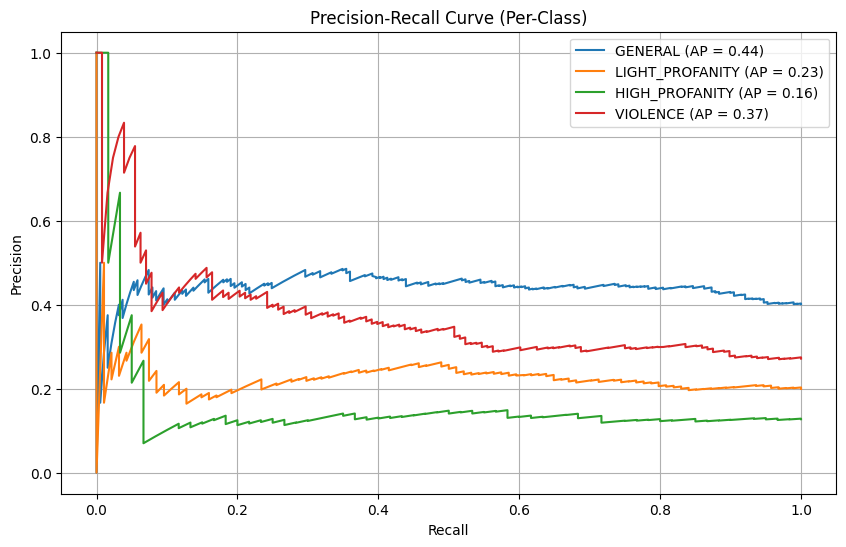

Confusion Matrix will be saved as ResBiLSTM_prev_cm.png


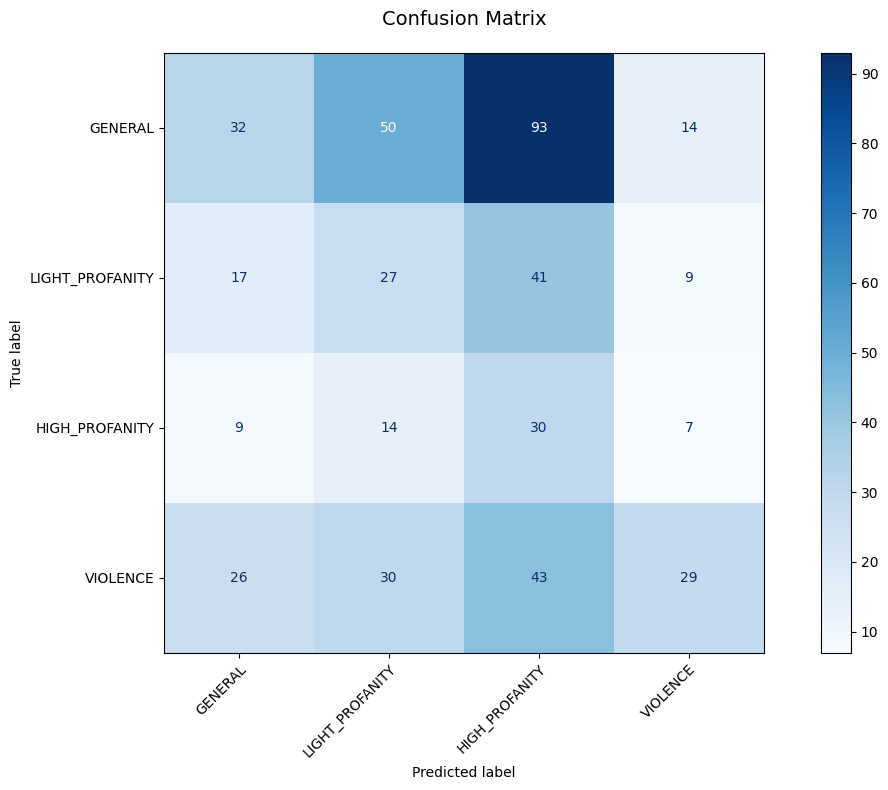

In [41]:
ResBiLSTM_prev_report = evaluate_model(ResBiLSTM_prev, test_loader, label_map, save_name="ResBiLSTM_prev")

## previous residual lstm implementation with high lr of 1e-4

In [42]:
ResBiLSTM_prev2_params = {
   "input_dim" : embeddings_size,
    "hidden_dim" : 148,
    "num_classes" : num_classes,
    "num_layers" : 1,
    "bidirectional" : True,
    "lr" : 1e-2,
    "weight_decay" : 1e-4,
    "train_batch_size" : 16,
    "test_batch_size" : 16,
    "val_batch_size" : 16,
    "dropout" : 0.4,
    "warmup_ratio" : 0.1,
    "epochs" : 20,
    "label_smoothing" : 0,
    "early_stopping_patience" : 3,
    "lstm_dropout" : 0
}

ResBiLSTM_prev2 = ResBiLSTMAttn_prev(
    input_dim=ResBiLSTM_prev2_params["input_dim"],
    hidden_dim=ResBiLSTM_prev2_params["hidden_dim"],
    num_classes=ResBiLSTM_prev2_params["num_classes"],
    num_layers= ResBiLSTM_prev2_params["num_layers"],
    dropout=ResBiLSTM_prev2_params["dropout"],
    bidirectional=ResBiLSTM_prev2_params["bidirectional"],
).to(device)

# Loss function
ResBiLSTM_prev2_criterion = nn.CrossEntropyLoss(label_smoothing=ResBiLSTM_prev2_params["label_smoothing"])

# Optimizer using unpacking
ResBiLSTM_prev2_optimizer = torch.optim.AdamW(
    ResBiLSTM_prev2.parameters(),
    lr=ResBiLSTM_prev2_params["lr"],
    weight_decay=ResBiLSTM_prev2_params["weight_decay"]
)


ResBiLSTM_prev2_scheduler = CosineAnnealingLR(ResBiLSTM_prev2_optimizer, T_max=len(train_loader) * ResBiLSTM_prev2_params["epochs"])

print(ResBiLSTM_prev2)
print("\n----------------------------------------------------\n")
print(count_parameters(ResBiLSTM_prev2))


ResBiLSTMAttn_prev(
  (lstm): ResLSTM(
    (dropout_layer): Dropout(p=0, inplace=False)
    (forward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
    (backward_cells): ModuleList(
      (0): ResLSTMLayer(
        (cell): ResLSTMCell()
      )
    )
  )
  (ln): LayerNorm((296,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (attn): Linear(in_features=296, out_features=1, bias=True)
  (fc): Linear(in_features=296, out_features=4, bias=True)
)

----------------------------------------------------

666893


Epoch 1/20 | Train Loss: 1.5855 | Val Loss: 3.9920 | Train F1: 0.2022 | Val F1: 0.0872
Epoch 2/20 | Train Loss: 5.0555 | Val Loss: 3.4949 | Train F1: 0.2613 | Val F1: 0.3107
Epoch 3/20 | Train Loss: 4.8797 | Val Loss: 6.1984 | Train F1: 0.2932 | Val F1: 0.2355
Epoch 4/20 | Train Loss: 2.7633 | Val Loss: 1.7359 | Train F1: 0.3464 | Val F1: 0.3521
Epoch 5/20 | Train Loss: 1.8870 | Val Loss: 2.0636 | Train F1: 0.3310 | Val F1: 0.3074
Epoch 6/20 | Train Loss: 1.6131 | Val Loss: 1.2874 | Train F1: 0.3693 | Val F1: 0.4041
Epoch 7/20 | Train Loss: 1.2970 | Val Loss: 1.0763 | Train F1: 0.4139 | Val F1: 0.4607
Epoch 8/20 | Train Loss: 1.1366 | Val Loss: 1.0878 | Train F1: 0.4779 | Val F1: 0.5304
Epoch 9/20 | Train Loss: 1.0561 | Val Loss: 1.1539 | Train F1: 0.4934 | Val F1: 0.4713
Epoch 10/20 | Train Loss: 0.9906 | Val Loss: 0.9260 | Train F1: 0.5277 | Val F1: 0.5279
Epoch 11/20 | Train Loss: 0.9093 | Val Loss: 0.8920 | Train F1: 0.5831 | Val F1: 0.5754
Epoch 12/20 | Train Loss: 0.8565 | Val Lo

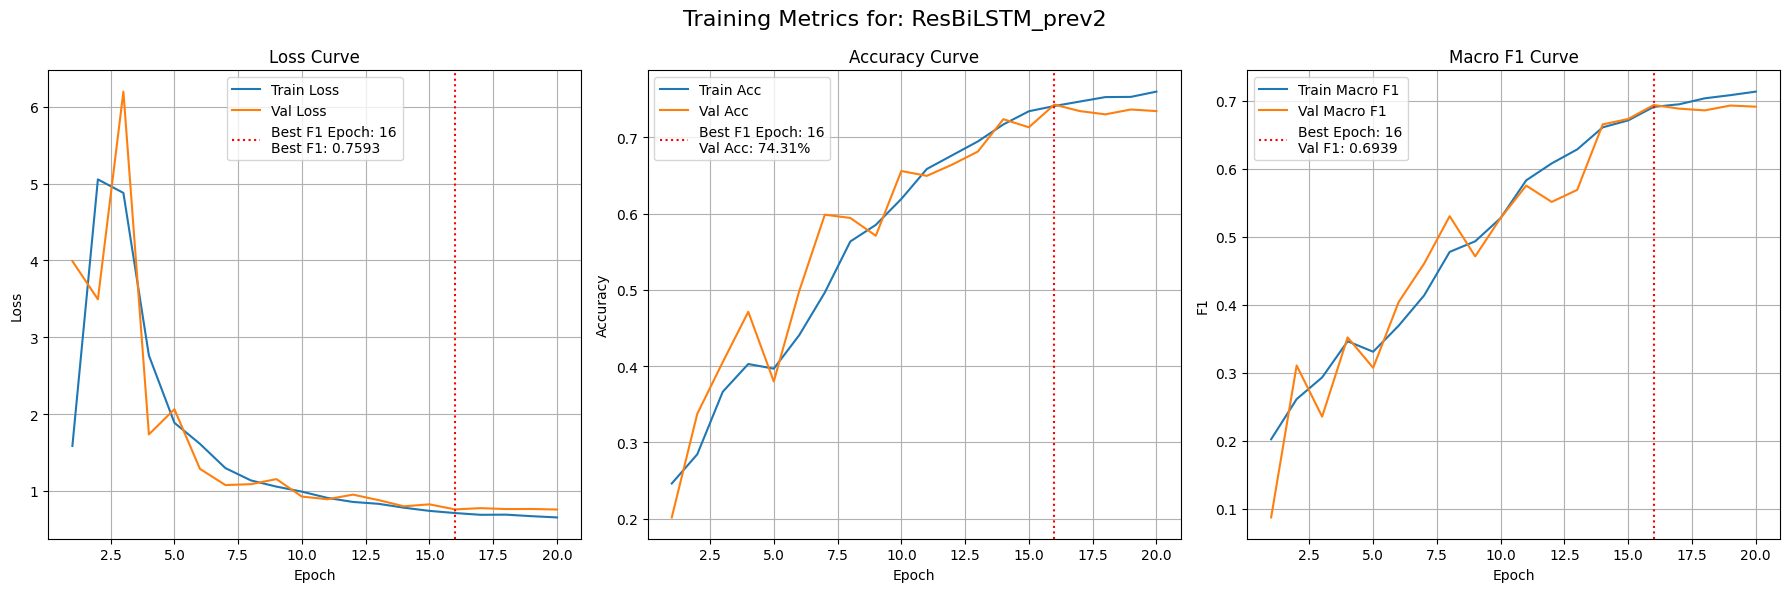

Matthews correlation coefficient: 0.636772078947869
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.87      0.86      0.87       190
LIGHT_PROFANITY       0.72      0.64      0.68        94
 HIGH_PROFANITY       0.56      0.50      0.53        60
       VIOLENCE       0.66      0.76      0.71       127

       accuracy                           0.74       471
      macro avg       0.70      0.69      0.69       471
   weighted avg       0.74      0.74      0.74       471



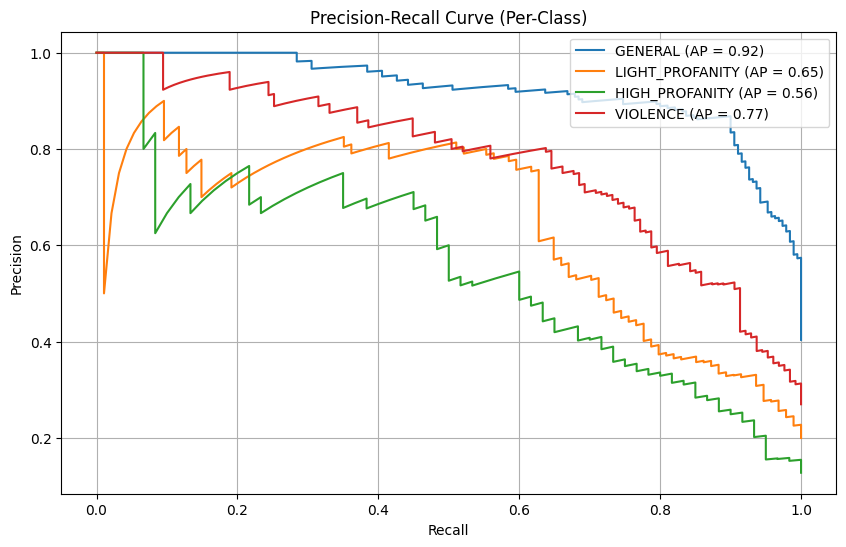

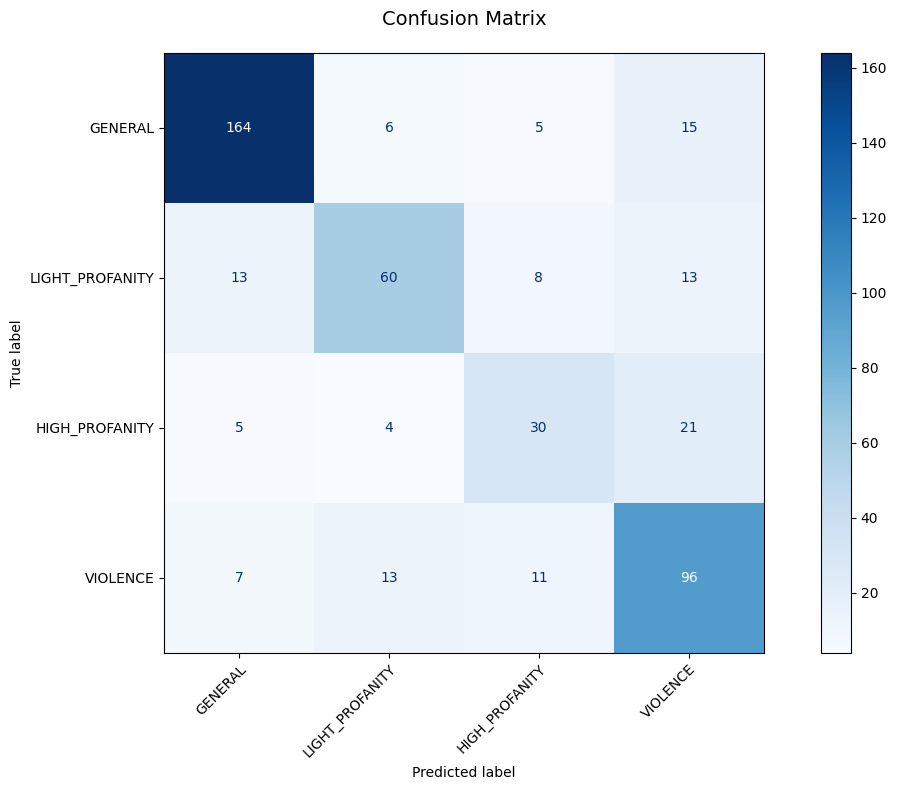

Matthews correlation coefficient: 0.6327856563614539
-------------------------------------

Classification Report:
                 precision    recall  f1-score   support

        GENERAL       0.89      0.81      0.85       189
LIGHT_PROFANITY       0.57      0.64      0.60        94
 HIGH_PROFANITY       0.64      0.63      0.64        60
       VIOLENCE       0.71      0.75      0.73       128

       accuracy                           0.74       471
      macro avg       0.70      0.71      0.70       471
   weighted avg       0.75      0.74      0.74       471

PR curve will be saved as ResBiLSTM_prev2_PR.png


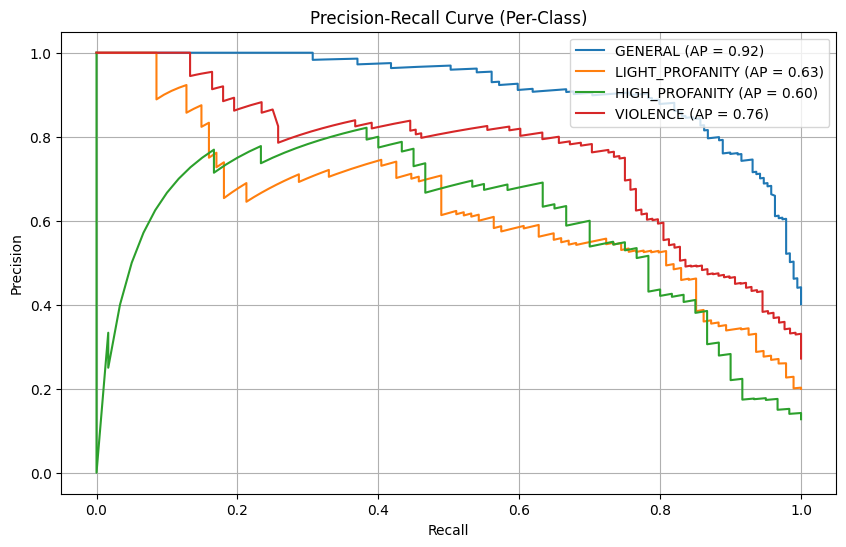

Confusion Matrix will be saved as ResBiLSTM_prev2_cm.png


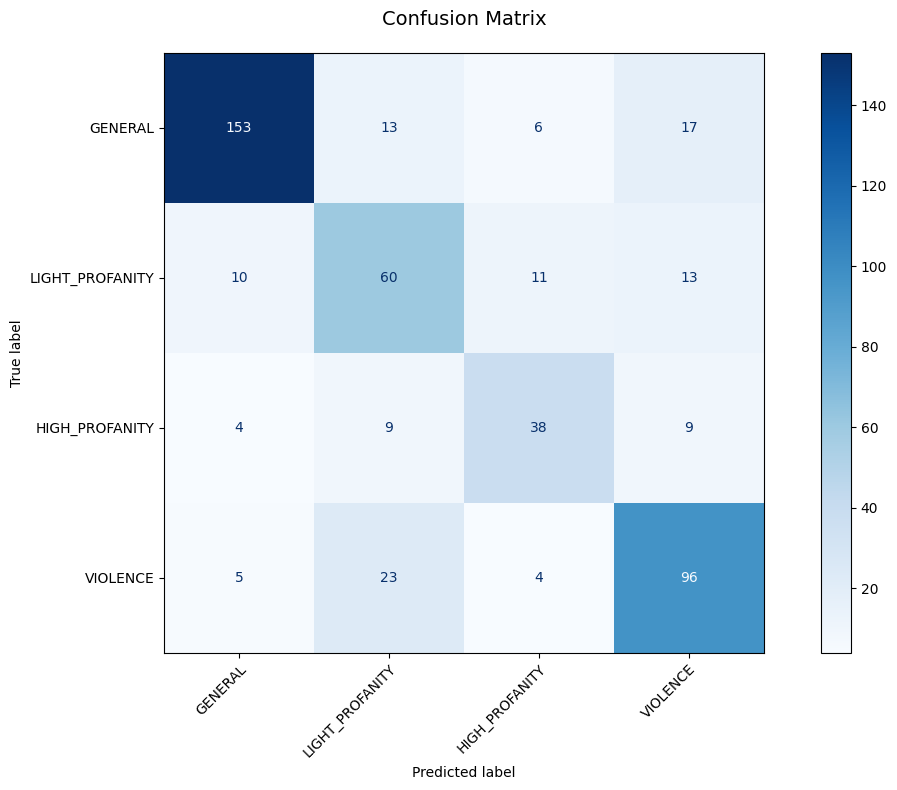

In [43]:
ResBiLSTM_prev2, ResBiLSTM_prev2_train_losses, ResBiLSTM_prev2_val_losses, ResBiLSTM_prev2_train_f1s, ResBiLSTM_prev2_val_f1s = model_train(ResBiLSTM_prev2, ResBiLSTM_prev2_criterion, ResBiLSTM_prev2_optimizer, train_loader, val_loader, scheduler=ResBiLSTM_prev2_scheduler, save_name="ResBiLSTM_prev2", epochs=ResBiLSTM_prev2_params["epochs"])
evaluate_model(ResBiLSTM_prev2, val_loader, label_map)
ResBiLSTM_prev2_report = evaluate_model(ResBiLSTM_prev2, test_loader, label_map, save_name="ResBiLSTM_prev2")

## MLFLOW Logging

In [44]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [45]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dagshub")

In [46]:
import mlflow, os
import pickle

os.environ["MLFLOW_TRACKING_USERNAME"] = "tamangangel2057"
os.environ["MLFLOW_TRACKING_PASSWORD"] = secret_value_0  

# Initialize MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/tamangangel2057/Nephased.mlflow")

# Initialize Mlflow experiment
experiment = mlflow.get_experiment_by_name("Word_embedding_reslstm")
experiment_id = experiment.experiment_id
print(experiment_id)

1


In [47]:
# Start the run

torch.save(dnn.state_dict(), "dnn_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_DNN"):
    mlflow.log_params(dnn_params)
    
    # For saving losses list
    losses = {
        "train_losses": dnn_train_losses,
        "val_losses": dnn_val_losses
    }
    loss_save_path = "/kaggle/working/dnn_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": dnn_train_f1s,
        "val_f1s": dnn_val_f1s
    }
    f1s_save_path = "/kaggle/working/dnn_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": dnn_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": dnn_report["0"]["precision"],
        "recall_0": dnn_report["0"]["recall"],
        "f1_0": dnn_report["0"]["f1-score"],
        "support_0": dnn_report["0"]["support"],

        "precision_1": dnn_report["1"]["precision"],
        "recall_1": dnn_report["1"]["recall"],
        "f1_1": dnn_report["1"]["f1-score"],
        "support_1": dnn_report["1"]["support"],

        "precision_2": dnn_report["2"]["precision"],
        "recall_2": dnn_report["2"]["recall"],
        "f1_2": dnn_report["2"]["f1-score"],
        "support_2": dnn_report["2"]["support"],

        "precision_3": dnn_report["3"]["precision"],
        "recall_3": dnn_report["3"]["recall"],
        "f1_3": dnn_report["3"]["f1-score"],
        "support_3": dnn_report["3"]["support"],

        # Macro average
        "macro_precision": dnn_report["macro avg"]["precision"],
        "macro_recall": dnn_report["macro avg"]["recall"],
        "macro_f1": dnn_report["macro avg"]["f1-score"],
        "macro_support": dnn_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": dnn_report["weighted avg"]["precision"],
        "weighted_recall": dnn_report["weighted avg"]["recall"],
        "weighted_f1": dnn_report["weighted avg"]["f1-score"],
        "weighted_support": dnn_report["weighted avg"]["support"],

        # MCC
        "mcc":dnn_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/DNN_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/DNN_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/DNN_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("dnn_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/dnn_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/dnn_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/dnn_losses.pkl
Losses saved: /kaggle/working/dnn_f1s.pkl
🏃 View run Word2Vec_DNN at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/48401e5dcd8f421580b7019ced4b9ab0
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [48]:
# Start the run

torch.save(BiLSTM.state_dict(), "BiLSTM_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_BiLSTM"):
    mlflow.log_params(BiLSTM_params)
    
    # For saving losses list
    losses = {
        "train_losses": BiLSTM_train_losses,
        "val_losses": BiLSTM_val_losses
    }
    loss_save_path = "/kaggle/working/BiLSTM_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": BiLSTM_train_f1s,
        "val_f1s": BiLSTM_val_f1s
    }
    f1s_save_path = "/kaggle/working/BiLSTM_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": BiLSTM_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": BiLSTM_report["0"]["precision"],
        "recall_0": BiLSTM_report["0"]["recall"],
        "f1_0": BiLSTM_report["0"]["f1-score"],
        "support_0": BiLSTM_report["0"]["support"],

        "precision_1": BiLSTM_report["1"]["precision"],
        "recall_1": BiLSTM_report["1"]["recall"],
        "f1_1": BiLSTM_report["1"]["f1-score"],
        "support_1": BiLSTM_report["1"]["support"],

        "precision_2": BiLSTM_report["2"]["precision"],
        "recall_2": BiLSTM_report["2"]["recall"],
        "f1_2": BiLSTM_report["2"]["f1-score"],
        "support_2": BiLSTM_report["2"]["support"],

        "precision_3": BiLSTM_report["3"]["precision"],
        "recall_3": BiLSTM_report["3"]["recall"],
        "f1_3": BiLSTM_report["3"]["f1-score"],
        "support_3": BiLSTM_report["3"]["support"],

        # Macro average
        "macro_precision": BiLSTM_report["macro avg"]["precision"],
        "macro_recall": BiLSTM_report["macro avg"]["recall"],
        "macro_f1": BiLSTM_report["macro avg"]["f1-score"],
        "macro_support": BiLSTM_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": BiLSTM_report["weighted avg"]["precision"],
        "weighted_recall": BiLSTM_report["weighted avg"]["recall"],
        "weighted_f1": BiLSTM_report["weighted avg"]["f1-score"],
        "weighted_support": BiLSTM_report["weighted avg"]["support"],

        # MCC
        "mcc":BiLSTM_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/BiLSTM_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("BiLSTM_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/BiLSTM_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/BiLSTM_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/BiLSTM_losses.pkl
Losses saved: /kaggle/working/BiLSTM_f1s.pkl
🏃 View run Word2Vec_BiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/8c632ffbe16949f9899da54ace8f56f5
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [49]:
# Start the run

torch.save(ResBiLSTM.state_dict(), "ResBiLSTM_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_ResBiLSTM"):
    mlflow.log_params(ResBiLSTM_params)
    
     # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_train_losses,
        "val_losses": ResBiLSTM_val_losses
    }
    loss_save_path = "/kaggle/working/ResBiLSTM_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": ResBiLSTM_train_f1s,
        "val_f1s": ResBiLSTM_val_f1s
    }
    f1s_save_path = "/kaggle/working/ResBiLSTM_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_report["0"]["precision"],
        "recall_0": ResBiLSTM_report["0"]["recall"],
        "f1_0": ResBiLSTM_report["0"]["f1-score"],
        "support_0": ResBiLSTM_report["0"]["support"],

        "precision_1": ResBiLSTM_report["1"]["precision"],
        "recall_1": ResBiLSTM_report["1"]["recall"],
        "f1_1": ResBiLSTM_report["1"]["f1-score"],
        "support_1": ResBiLSTM_report["1"]["support"],

        "precision_2": ResBiLSTM_report["2"]["precision"],
        "recall_2": ResBiLSTM_report["2"]["recall"],
        "f1_2": ResBiLSTM_report["2"]["f1-score"],
        "support_2": ResBiLSTM_report["2"]["support"],

        "precision_3": ResBiLSTM_report["3"]["precision"],
        "recall_3": ResBiLSTM_report["3"]["recall"],
        "f1_3": ResBiLSTM_report["3"]["f1-score"],
        "support_3": ResBiLSTM_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_losses.pkl
Losses saved: /kaggle/working/ResBiLSTM_f1s.pkl
🏃 View run Word2Vec_ResBiLSTM at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/a659aea358564e2f824d5fd59f1ce980
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [50]:
# Start the run

torch.save(BiLSTM2.state_dict(), "BiLSTM2_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_BiLSTM2"):
    mlflow.log_params(BiLSTM2_params)
    
    # For saving losses list
    losses = {
        "train_losses": BiLSTM2_train_losses,
        "val_losses": BiLSTM2_val_losses
    }
    loss_save_path = "/kaggle/working/BiLSTM2_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": BiLSTM2_train_f1s,
        "val_f1s": BiLSTM2_val_f1s
    }
    f1s_save_path = "/kaggle/working/BiLSTM2_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": BiLSTM2_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": BiLSTM2_report["0"]["precision"],
        "recall_0": BiLSTM2_report["0"]["recall"],
        "f1_0": BiLSTM2_report["0"]["f1-score"],
        "support_0": BiLSTM2_report["0"]["support"],

        "precision_1": BiLSTM2_report["1"]["precision"],
        "recall_1": BiLSTM2_report["1"]["recall"],
        "f1_1": BiLSTM2_report["1"]["f1-score"],
        "support_1": BiLSTM2_report["1"]["support"],

        "precision_2": BiLSTM2_report["2"]["precision"],
        "recall_2": BiLSTM2_report["2"]["recall"],
        "f1_2": BiLSTM2_report["2"]["f1-score"],
        "support_2": BiLSTM2_report["2"]["support"],

        "precision_3": BiLSTM2_report["3"]["precision"],
        "recall_3": BiLSTM2_report["3"]["recall"],
        "f1_3": BiLSTM2_report["3"]["f1-score"],
        "support_3": BiLSTM2_report["3"]["support"],

        # Macro average
        "macro_precision": BiLSTM2_report["macro avg"]["precision"],
        "macro_recall": BiLSTM2_report["macro avg"]["recall"],
        "macro_f1": BiLSTM2_report["macro avg"]["f1-score"],
        "macro_support": BiLSTM2_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": BiLSTM2_report["weighted avg"]["precision"],
        "weighted_recall": BiLSTM2_report["weighted avg"]["recall"],
        "weighted_f1": BiLSTM2_report["weighted avg"]["f1-score"],
        "weighted_support": BiLSTM2_report["weighted avg"]["support"],

        # MCC
        "mcc":BiLSTM2_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/BiLSTM2_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM2_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/BiLSTM2_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("BiLSTM2_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/BiLSTM2_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/BiLSTM2_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/BiLSTM2_losses.pkl
Losses saved: /kaggle/working/BiLSTM2_f1s.pkl
🏃 View run Word2Vec_BiLSTM2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/7b6302a59a184a5aa6789fc6c7d64ca9
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [51]:
# Start the run

torch.save(ResBiLSTM_prev.state_dict(), "ResBiLSTM_prev_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_ResBiLSTM_prev"):
    mlflow.log_params(ResBiLSTM_prev_params)
    
    # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_prev_train_losses,
        "val_losses": ResBiLSTM_prev_val_losses
    }
    loss_save_path = "/kaggle/working/ResBiLSTM_prev_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": ResBiLSTM_prev_train_f1s,
        "val_f1s": ResBiLSTM_prev_val_f1s
    }
    f1s_save_path = "/kaggle/working/ResBiLSTM_prev_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_prev_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_prev_report["0"]["precision"],
        "recall_0": ResBiLSTM_prev_report["0"]["recall"],
        "f1_0": ResBiLSTM_prev_report["0"]["f1-score"],
        "support_0": ResBiLSTM_prev_report["0"]["support"],

        "precision_1": ResBiLSTM_prev_report["1"]["precision"],
        "recall_1": ResBiLSTM_prev_report["1"]["recall"],
        "f1_1": ResBiLSTM_prev_report["1"]["f1-score"],
        "support_1": ResBiLSTM_prev_report["1"]["support"],

        "precision_2": ResBiLSTM_prev_report["2"]["precision"],
        "recall_2": ResBiLSTM_prev_report["2"]["recall"],
        "f1_2": ResBiLSTM_prev_report["2"]["f1-score"],
        "support_2": ResBiLSTM_prev_report["2"]["support"],

        "precision_3": ResBiLSTM_prev_report["3"]["precision"],
        "recall_3": ResBiLSTM_prev_report["3"]["recall"],
        "f1_3": ResBiLSTM_prev_report["3"]["f1-score"],
        "support_3": ResBiLSTM_prev_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_prev_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_prev_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_prev_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_prev_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_prev_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_prev_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_prev_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_prev_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_prev_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_prev_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_prev_losses.pkl
Losses saved: /kaggle/working/ResBiLSTM_prev_f1s.pkl
🏃 View run Word2Vec_ResBiLSTM_prev at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/d2959b7a82bb49f5b01d8306cd95d6c1
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1


In [52]:
# Start the run

torch.save(ResBiLSTM_prev2.state_dict(), "ResBiLSTM_prev2_state_dict.pt")

with mlflow.start_run(experiment_id=experiment_id, run_name="Word2Vec_ResBiLSTM_prev2"):
    mlflow.log_params(ResBiLSTM_prev2_params)
    
    # For saving losses list
    losses = {
        "train_losses": ResBiLSTM_prev2_train_losses,
        "val_losses": ResBiLSTM_prev2_val_losses
    }
    loss_save_path = "/kaggle/working/ResBiLSTM_prev2_losses.pkl"
    try:
        with open(loss_save_path, "wb") as f:
            pickle.dump(losses, f)
        print(f"Losses saved: {loss_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    # For saving f1s list
    f1s = {
        "train_f1s": ResBiLSTM_prev2_train_f1s,
        "val_f1s": ResBiLSTM_prev2_val_f1s
    }
    f1s_save_path = "/kaggle/working/ResBiLSTM_prev2_f1s.pkl"
    try:
        with open(f1s_save_path, "wb") as f:
            pickle.dump(f1s, f)
        print(f"Losses saved: {f1s_save_path}")
    except Exception as e:
        print(f"Failed to save losses: {str(e)}")

    mlflow.log_metrics({
        # Global accuracy
        "accuracy": ResBiLSTM_prev2_report["accuracy"],

        # Per-class metrics (0 to 3)
        "precision_0": ResBiLSTM_prev2_report["0"]["precision"],
        "recall_0": ResBiLSTM_prev2_report["0"]["recall"],
        "f1_0": ResBiLSTM_prev2_report["0"]["f1-score"],
        "support_0": ResBiLSTM_prev2_report["0"]["support"],

        "precision_1": ResBiLSTM_prev2_report["1"]["precision"],
        "recall_1": ResBiLSTM_prev2_report["1"]["recall"],
        "f1_1": ResBiLSTM_prev2_report["1"]["f1-score"],
        "support_1": ResBiLSTM_prev2_report["1"]["support"],

        "precision_2": ResBiLSTM_prev2_report["2"]["precision"],
        "recall_2": ResBiLSTM_prev2_report["2"]["recall"],
        "f1_2": ResBiLSTM_prev2_report["2"]["f1-score"],
        "support_2": ResBiLSTM_prev2_report["2"]["support"],

        "precision_3": ResBiLSTM_prev2_report["3"]["precision"],
        "recall_3": ResBiLSTM_prev2_report["3"]["recall"],
        "f1_3": ResBiLSTM_prev2_report["3"]["f1-score"],
        "support_3": ResBiLSTM_prev2_report["3"]["support"],

        # Macro average
        "macro_precision": ResBiLSTM_prev2_report["macro avg"]["precision"],
        "macro_recall": ResBiLSTM_prev2_report["macro avg"]["recall"],
        "macro_f1": ResBiLSTM_prev2_report["macro avg"]["f1-score"],
        "macro_support": ResBiLSTM_prev2_report["macro avg"]["support"],

        # Weighted average
        "weighted_precision": ResBiLSTM_prev2_report["weighted avg"]["precision"],
        "weighted_recall": ResBiLSTM_prev2_report["weighted avg"]["recall"],
        "weighted_f1": ResBiLSTM_prev2_report["weighted avg"]["f1-score"],
        "weighted_support": ResBiLSTM_prev2_report["weighted avg"]["support"],

        # MCC
        "mcc":ResBiLSTM_prev2_report["mcc"],
    })

    # Log all plots
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_loss.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_PR.png", artifact_path="plots")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_cm.png", artifact_path="plots")

    # Log weights
    mlflow.log_artifact("ResBiLSTM_prev2_state_dict.pt", artifact_path="model")

    # Log losses
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_losses.pkl", artifact_path="Losses")
    mlflow.log_artifact("/kaggle/working/ResBiLSTM_prev2_f1s.pkl", artifact_path="Losses")

Losses saved: /kaggle/working/ResBiLSTM_prev2_losses.pkl
Losses saved: /kaggle/working/ResBiLSTM_prev2_f1s.pkl
🏃 View run Word2Vec_ResBiLSTM_prev2 at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1/runs/e6c0e6b21165441e98fab9d562658a31
🧪 View experiment at: https://dagshub.com/tamangangel2057/Nephased.mlflow/#/experiments/1
